In [577]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import gaussian_kde
# import ctx
import contextily as ctx
import statsmodels.api as cm

In [578]:
# import data
data_raw = pd.read_csv('data/merged_df.csv')

## **1. Data Cleaning**

In [579]:
# delete all repeated rows
data_raw2 = data_raw.drop_duplicates()

In [580]:
# delete all strings after "/" in the ipc_code column
data_raw2['ipc_code'] = data_raw2['ipc_code'].str.split('/').str[0]

/var/folders/2t/z358mxvn5gs4nb74zwpfwg5m0000gn/T/ipykernel_22457/3081754037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw2['ipc_code'] = data_raw2['ipc_code'].str.split('/').str[0]


In [581]:
# delete all repeated rows
data_raw3 = data_raw2.drop_duplicates()

In [582]:
data_raw3.shape

(303380, 12)

In [583]:
# clean the data, group all rows with the same appln_id, take the first value for each column, 
# except for the 'ipc_code' column, combine all values into a list saved as the new value for column 'ipc_code'
data = data_raw3.groupby('appln_id').agg({
    'ipc_code': lambda x: list(x),
    'patent_office': 'first',
    'filing_date': 'first',
    'lat': 'first',
    'lng': 'first',
    'name_0': 'first',
    'name_1': 'first',
    'name_2': 'first',
    'name_3': 'first',
    'city': 'first',
    'type': 'first'
}).reset_index()


In [584]:
data.sample(10)

appln_id                ipc_code patent_office filing_date        lat  \
109973  23210837          [H04B7, H04Q7]            GB  21/01/1997  51.488899   
105269  23172722         [G01S7, G01S17]            GB  18/10/1995  55.968899   
29973   21382811  [B60R21, B60T7, G05G1]            GB  29/05/2002  52.432899   
123808  29038001        [G06Q40, G06Q50]            JP  15/03/1991  51.567402   
106986  23187902                [G01N33]            GB  28/03/1996  52.185001   
109008  23202777         [B60J1, E05F11]            GB  15/10/1996  52.205101   
75089   22898125         [G09F21, G09G3]            GB  26/09/1986  51.587799   
32072   21397207                [F16L11]            GB  18/11/2002  52.896999   
27167   21360606                [G09F13]            GB  05/11/2001  51.456600   
94974   23083074        [B29C45, F16L33]            GB  03/10/1992  51.692200   

             lng          name_0    name_1            name_2  \
109973 -0.228275  United Kingdom   England    Greater London   
105269 -3.247550  United Kingdom  Scotland         Edinburgh   
29973  -1.895940  United Kingdom   England        Birmingham   
123808 -1.234210  United Kingdom   England       Oxfordshire   
106986  0.144177  United Kingdom   England    Cambridgeshire   
109008 -0.902384  United Kingdom   England  Northamptonshire   
75089  -0.340440  United Kingdom   England    Greater London   
32072  -1.503910  United Kingdom   England             Derby   
27167  -0.182473  United Kingdom   England    Greater London   
94974   0.582771  United Kingdom   England             Essex   

                        name_3                  city      type  
109973  Hammersmith and Fulham                London  priority  
105269               Edinburgh             Edinburgh    single  
29973               Birmingham            Birmingham  priority  
123808       South Oxfordshire     South Oxfordshire  tech_rel  
106986    South Cambridgeshire  South Cambridgeshire    single  
109008             Northampton           Northampton    single  
75089                   Harrow                London  priority  
32072                    Derby                 Derby    single  
27167               Wandsworth                London    single  
94974               Chelmsford            Chelmsford    single

In [585]:
# print the number of unique appln_id
print(len(data['appln_id'].unique()))

139926


In [586]:
# convert the filing_date column to string
data['filing_date'] = data['filing_date'].astype(str)

In [587]:
# create the 'year', 'month', 'day' columns derived from the 'filing_date' column, format is "%d/%m/%Y"
data['year'] = pd.DatetimeIndex(data['filing_date']).year
data['month'] = pd.DatetimeIndex(data['filing_date']).month
data['day'] = pd.DatetimeIndex(data['filing_date']).day
# convert the filing_date column to datetime
data['filing_date'] = pd.to_datetime(data['filing_date'], format='%d/%m/%Y')

data.sample(3)


appln_id                 ipc_code patent_office filing_date        lat  \
10933  16598371                  [A23K1]            EP  1985-04-01  51.245899   
5473   15927597           [G02B6, H02G3]            EP  2002-03-28  50.875198   
74786  22895420  [B01D3, F25B13, F25B40]            GB  1986-08-23  52.501499   

            lng          name_0   name_1       name_2     name_3       city  \
10933 -0.583188  United Kingdom  England       Surrey  Guildford  Guildford   
5473   0.555129  United Kingdom  England  East Sussex   Hastings   Hastings   
74786 -3.339840  United Kingdom    Wales        Powys      Powys      Powys   

           type  year  month  day  
10933  priority  1985      1    4  
5473     single  2002      3   28  
74786  priority  1986      8   23

In [588]:
# check the time range of the data based on the 'filling_date' column

data['filing_date'].describe()

count                           139926
mean     1996-02-29 15:48:19.789888896
min                1980-01-02 00:00:00
25%                1988-12-28 06:00:00
50%                1997-05-21 00:00:00
75%                2003-02-10 18:00:00
max                2008-09-30 00:00:00
Name: filing_date, dtype: object

In [589]:
# convert the data to the geopandas dataframe based on the 'lat' and 'lng'  columns
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lng, data.lat))
gdf.crs = {'init': 'epsg:4326'}

/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [590]:
# filter all data with ipc_code column containing string G06 in any element of the list, so we could get all data related to G06
gdf_data_G06 = gdf[gdf['ipc_code'].apply(lambda x: any('G06' in s for s in x))]
print(gdf_data_G06.shape)
gdf_data_G06.sample(5)

(10917, 16)


appln_id                        ipc_code patent_office filing_date  \
31547   21393721  [A47F9, G06Q30, G07G1, G09F21]            GB  2002-10-08   
39062   21447672                  [G06F1, H05K5]            GB  2004-05-28   
46545   21493071           [G06T1, H04N1, H04N5]            GB  2006-02-10   
69737   22845626  [B42D15, B44C1, B44F1, G06K19]            GB  1985-02-07   
135829  52217928                         [G06T3]            US  1996-02-28   

              lat       lng          name_0   name_1  \
31547   51.370399 -2.363910  United Kingdom  England   
39062   52.032902 -0.786153  United Kingdom  England   
46545   52.595600 -2.212480  United Kingdom  England   
69737   51.072102 -0.407821  United Kingdom  England   
135829  51.809799 -0.237674  United Kingdom  England   

                              name_2                        name_3  \
31547   Bath and North East Somerset  Bath and North East Somerset   
39062                  Milton Keynes                 Milton Keynes   
46545                  Staffordshire           South Staffordshire   
69737                    West Sussex                       Horsham   
135829                 Hertfordshire               Welwyn Hatfield   

                                city      type  year  month  day  \
31547   Bath and North East Somerset  priority  2002      8   10   
39062                  Milton Keynes  priority  2004      5   28   
46545            South Staffordshire  priority  2006     10    2   
69737                        Horsham  priority  1985      7    2   
135829               Welwyn Hatfield    single  1996      2   28   

                         geometry  
31547   POINT (-2.36391 51.37040)  
39062   POINT (-0.78615 52.03290)  
46545   POINT (-2.21248 52.59560)  
69737   POINT (-0.40782 51.07210)  
135829  POINT (-0.23767 51.80980)

**filter all data ealier than 31/12/2007, due to the description from GOV.uk, patent is normally published 18 months after filing. Applications filed but not published are not included in this dataset(https://www.gov.uk/government/publications/ipo-patent-data/ipo-patent-data-explained--2#/)**

In [591]:
# filter all data with filing_date earlier than 30/03/2007
gdf_data_G06 = gdf_data_G06[gdf_data_G06['filing_date'] < '2006-12-31']

## **2. Software Patents**
### **2.1 EDA**

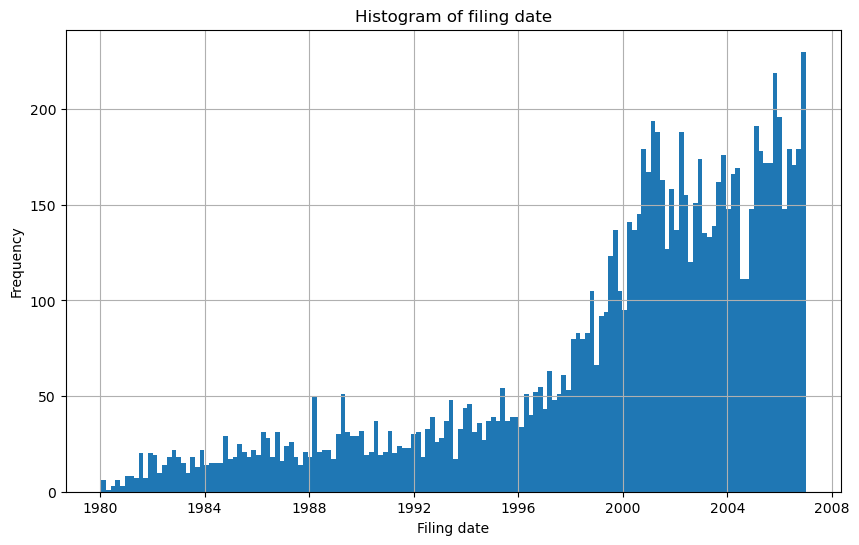

In [592]:
# plot the histogram based on the date time
fig, ax = plt.subplots(figsize=(10, 6))
gdf_data_G06['filing_date'].hist(bins=150, ax=ax)
ax.set_title('Histogram of filing date')
ax.set_xlabel('Filing date')
ax.set_ylabel('Frequency')
plt.show()

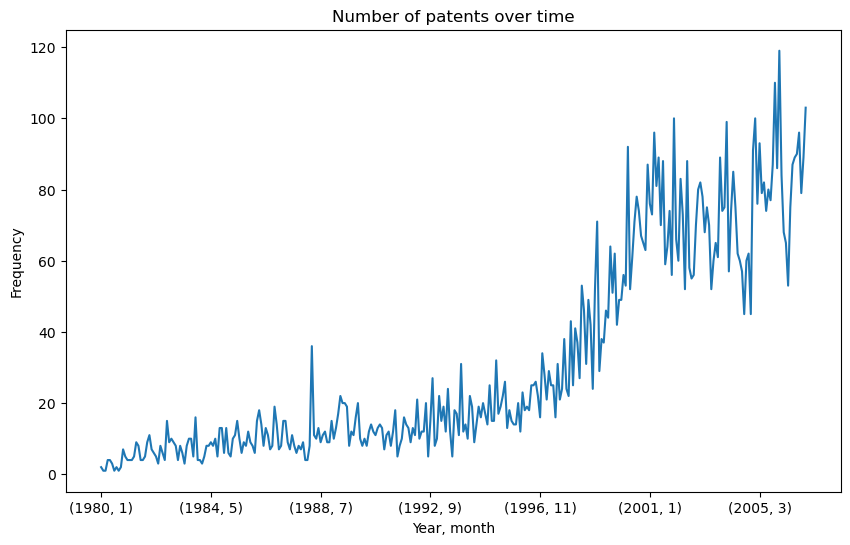

In [593]:
# plot the line graph based on the date time, only refer to the year and month, not the day
fig, ax = plt.subplots(figsize=(10, 6))
gdf_data_G06.groupby(['year', 'month']).size().plot(ax=ax)
ax.set_title('Number of patents over time')
# set the x-axis label to be the year and month
ax.set_xlabel('Year, month')
ax.set_ylabel('Frequency')
plt.show()

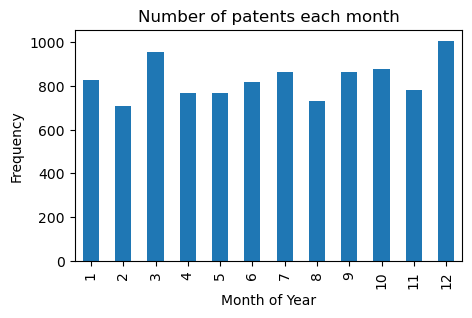

In [594]:
# plot the histogram based on the month, with their unique values， but not in the sorted order, the x-axis is the month
fig, ax = plt.subplots(figsize=(5, 3))
# sorted the month based on the month number
gdf_data_G06['month'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Number of patents each month')
ax.set_xlabel('Month of Year')
ax.set_ylabel('Frequency')
plt.show()

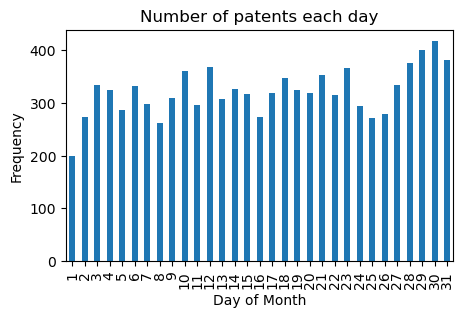

In [595]:
# plot the histogram based on the day, with their unique values， but not in the sorted order, the x-axis is the month
fig, ax = plt.subplots(figsize=(5, 3))
# sorted the month based on the month number
gdf_data_G06['day'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Number of patents each day')
ax.set_xlabel('Day of Month')
ax.set_ylabel('Frequency')
plt.show()

**Patenting by Cities over Time**

In [596]:
# print how many unique values in the 'city' column
print(f"There are {gdf_data_G06['city'].nunique()} unique values in the 'city' column, meaning there are {gdf_data_G06['city'].nunique()} cities in the data")

There are 343 unique values in the 'city' column, meaning there are 343 cities in the data


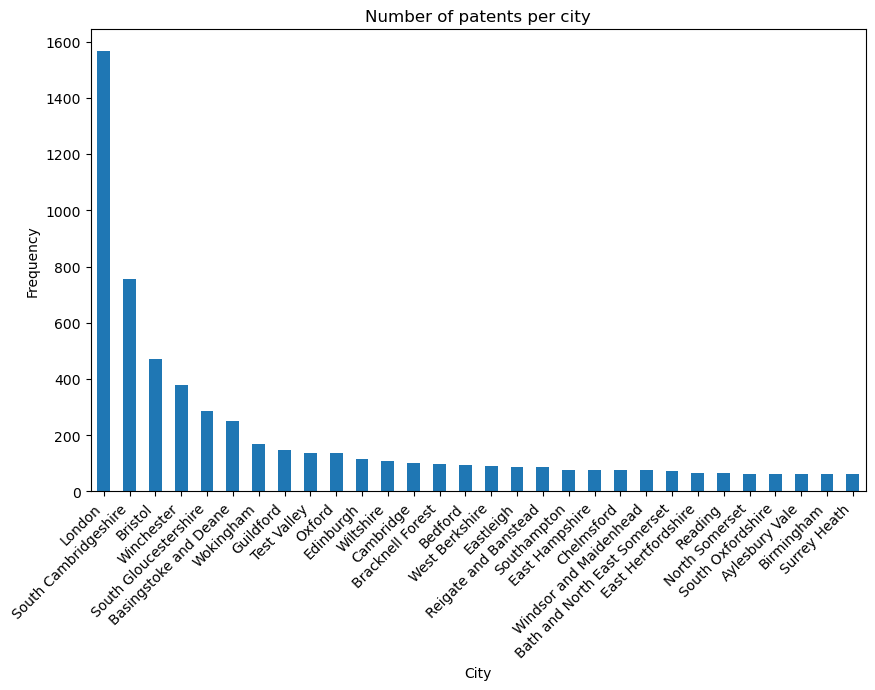

In [597]:
# plot and set the x label as 45 degree with right alignment

fig, ax = plt.subplots(figsize=(10, 6))
gdf_data_G06['city'].value_counts().head(30).plot(kind='bar', ax=ax)
ax.set_title('Number of patents per city')
ax.set_xlabel('City')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


In [598]:
# check top 1%(1st to 3rd), top 5%(4th to 17th), everywhere else's cities name for number of patents.

# top 1, top 2, top 3
top_1 = gdf_data_G06['city'].value_counts().head(1).index.to_list()
top_2 = gdf_data_G06['city'].value_counts().iloc[1:2].index.to_list()
top_3 = gdf_data_G06['city'].value_counts().iloc[2:3].index.to_list()
# top 4 to top 17
top_5percent = gdf_data_G06['city'].value_counts().iloc[3:17].index.to_list()
# the rest
the_rest = gdf_data_G06['city'].value_counts().iloc[17:].index.to_list()


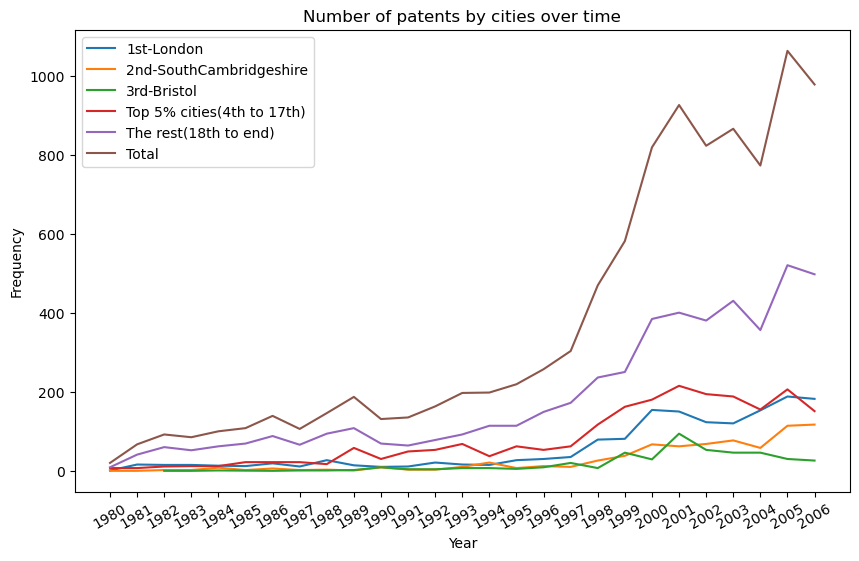

In [599]:
# plot the line graph for top1, top2, top3, top5 and the rest seperately, based on their number of patents over time
fig, ax = plt.subplots(figsize=(10, 6))
gdf_data_G06[gdf_data_G06['city'].isin(top_1)].groupby('year').size().plot(ax=ax, label='1st-London')
gdf_data_G06[gdf_data_G06['city'].isin(top_2)].groupby('year').size().plot(ax=ax, label='2nd-SouthCambridgeshire')
gdf_data_G06[gdf_data_G06['city'].isin(top_3)].groupby('year').size().plot(ax=ax, label='3rd-Bristol')
gdf_data_G06[gdf_data_G06['city'].isin(top_5percent)].groupby('year').size().plot(ax=ax, label='Top 5% cities(4th to 17th)')
gdf_data_G06[gdf_data_G06['city'].isin(the_rest)].groupby('year').size().plot(ax=ax, label='The rest(18th to end)')
# plot the total number of patents over time
gdf_data_G06.groupby('year').size().plot(ax=ax, label='Total')
ax.set_title('Number of patents by cities over time')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_xticks(gdf_data_G06['year'].unique())  # Set the x-ticks to be all unique years in the data
ax.set_xticklabels(gdf_data_G06['year'].unique(), rotation=30)  # Rotate labels if needed for better readability

plt.legend()
plt.show()

**Software Patent Within Types data**

In [600]:
gdf_data_G06

appln_id                                           ipc_code  \
35          4577  [G06K9, G06T9, G10L15, G10L21, H03M7, H04N1, H...   
61          8665                                            [G06F1]   
64         13814                                           [G06F13]   
81         24311                                           [G06F12]   
136        39641                                   [G06Q10, H04L12]   
...          ...                                                ...   
139910  53885408                                           [G06F12]   
139918  53888683                                           [G06Q40]   
139923  53891143                                   [G06Q10, G06Q30]   
139924  53891660                                    [G06F7, G06F17]   
139925  53892190                                           [G06F21]   

       patent_office filing_date        lat       lng          name_0  \
35                EP  1986-11-10  52.116798  1.153290  United Kingdom   
61                WO  2006-12-27  51.335400 -0.742856  United Kingdom   
64                WO  2006-12-28  51.196800 -0.606196  United Kingdom   
81                EP  2002-05-30  51.438900 -2.853380  United Kingdom   
136               EP  2005-12-02  52.203701  0.124092  United Kingdom   
...              ...         ...        ...       ...             ...   
139910            US  2004-06-10  54.695900 -1.751560  United Kingdom   
139918            US  2004-06-14  51.507401 -0.127758  United Kingdom   
139923            US  2001-05-25  51.353298 -0.691902  United Kingdom   
139924            US  2004-06-11  51.487598 -0.267173  United Kingdom   
139925            US  1997-06-02  51.752701 -0.339436  United Kingdom   

         name_1          name_2                name_3                  city  \
35      England         Suffolk           Mid Suffolk           Mid Suffolk   
61      England          Surrey          Surrey Heath          Surrey Heath   
64      England          Surrey              Waverley              Waverley   
81      England  North Somerset        North Somerset        North Somerset   
136     England  Cambridgeshire  South Cambridgeshire  South Cambridgeshire   
...         ...             ...                   ...                   ...   
139910  England          Durham                Durham                Durham   
139918  England  Greater London           Westminster                London   
139923  England          Surrey          Surrey Heath          Surrey Heath   
139924  England  Greater London              Hounslow                London   
139925  England   Hertfordshire          Saint Albans          Saint Albans   

            type  year  month  day                   geometry  
35      priority  1986     10   11   POINT (1.15329 52.11680)  
61           pct  2006     12   27  POINT (-0.74286 51.33540)  
64           pct  2006     12   28  POINT (-0.60620 51.19680)  
81      priority  2002      5   30  POINT (-2.85338 51.43890)  
136     priority  2005      2   12   POINT (0.12409 52.20370)  
...          ...   ...    ...  ...                        ...  
139910    single  2004     10    6  POINT (-1.75156 54.69590)  
139918    single  2004      6   14  POINT (-0.12776 51.50740)  
139923  priority  2001      5   25  POINT (-0.69190 51.35330)  
139924    single  2004     11    6  POINT (-0.26717 51.48760)  
139925    single  1997      2    6  POINT (-0.33944 51.75270)  

[9971 rows x 16 columns]

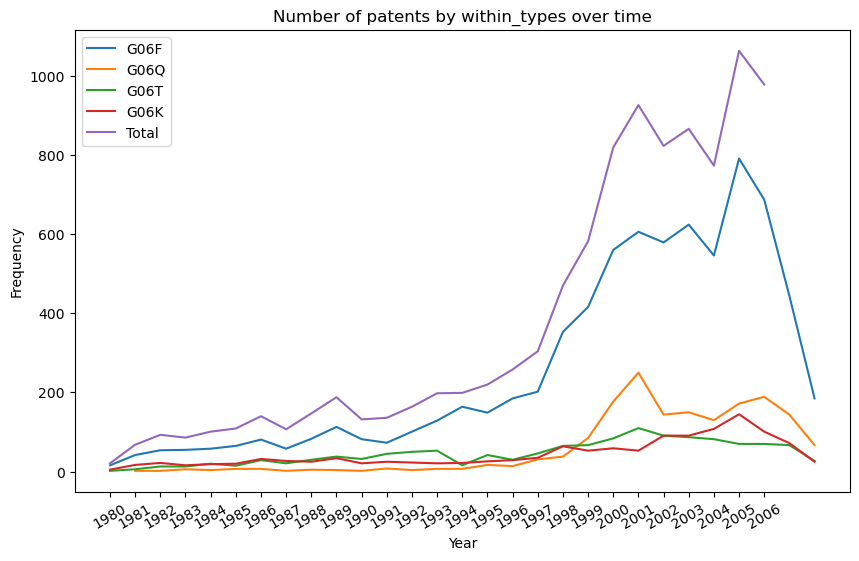

In [601]:
# filter all data with ipc_code column containing string G06F
gdf_data_G06F = gdf[gdf['ipc_code'].apply(lambda x: any('G06F' in s for s in x))]
gdf_data_G06Q = gdf[gdf['ipc_code'].apply(lambda x: any('G06Q' in s for s in x))]
gdf_data_G06T = gdf[gdf['ipc_code'].apply(lambda x: any('G06T' in s for s in x))]
gdf_data_G06K = gdf[gdf['ipc_code'].apply(lambda x: any('G06K' in s for s in x))]

# plot the line graph for f,q,t,k seperately, based on their number of patents over time
fig, ax = plt.subplots(figsize=(10, 6))
gdf_data_G06F.groupby('year').size().plot(ax=ax, label='G06F')
gdf_data_G06Q.groupby('year').size().plot(ax=ax, label='G06Q')
gdf_data_G06T.groupby('year').size().plot(ax=ax, label='G06T')
gdf_data_G06K.groupby('year').size().plot(ax=ax, label='G06K')
# plot the total number of patents over time
gdf_data_G06.groupby('year').size().plot(ax=ax, label='Total')
ax.set_title('Number of patents by within_types over time')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_xticks(gdf_data_G06['year'].unique())  # Set the x-ticks to be all unique years in the data
ax.set_xticklabels(gdf_data_G06['year'].unique(), rotation=30)  # Rotate labels if needed for better readability

plt.legend()
plt.show()

### **3.2 Geoinfo Plotting**

In [602]:
# import the shpaefile data
Boundary = gpd.read_file('data/Boundary/NUTS2_Jan_2018_UGCB_in_the_UK.shp')
# set the crs to the 27700
Boundary = Boundary.to_crs(epsg=27700)
# set the crs of the gdf_data_G06 to the crs of the Boundary
gdf_data_G06 = gdf_data_G06.to_crs(Boundary.crs)


In [603]:
Boundary.sample(4)

nuts218cd                                       nuts218nm   bng_e   bng_n  \
14      UKG1  Herefordshire, Worcestershire and Warwickshire  390692  262189   
13      UKF3                                    Lincolnshire  517985  358543   
31      UKK3                    Cornwall and Isles of Scilly  212501   64494   
11      UKF1                  Derbyshire and Nottinghamshire  449616  357965   

       long        lat                              GlobalID  \
14 -2.13777  52.257801  1d8d52be-8b4b-4f85-b775-10e2508ee862   
13 -0.23882  53.111050  d8462260-97c1-46bf-884a-82facc7d4569   
31 -4.64249  50.450230  7ce71797-d82b-4fe2-b94b-bc96d83f395d   
11 -1.26015  53.116581  29825280-185a-4f30-bece-cc53f2069dbd   

                                             geometry  
14  POLYGON ((429849.397 299906.502, 432135.200 29...  
13  POLYGON ((516022.702 412210.895, 515854.099 41...  
31  MULTIPOLYGON (((229169.697 98911.096, 230214.0...  
11  POLYGON ((408481.200 404870.596, 410585.199 40...

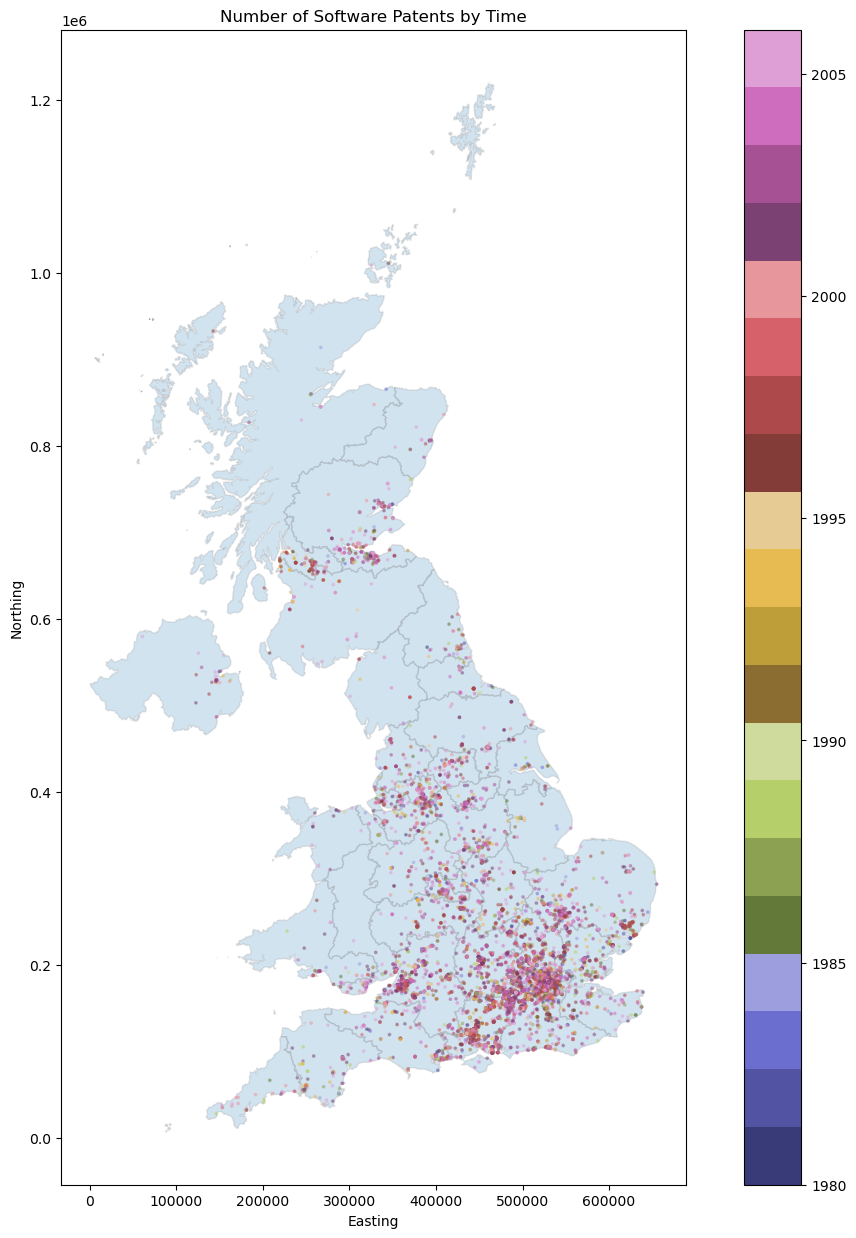

In [604]:
# plot the Boundary data and the gdf_data_G06 data, based on the crs 4326,
fig, ax = plt.subplots(figsize=(15, 15))
Boundary.plot(ax=ax, alpha=0.2, edgecolor='grey')
# label each boundary with the 'CTYUA23NM' column
#for x, y, label in zip(Boundary.geometry.centroid.x, Boundary.geometry.centroid.y, Boundary['CTYUA23NM']):
   #ax.text(x, y, label, fontsize=5, ha='center')
gdf_data_G06.plot(ax=ax, alpha=0.4, legend=True, column='year', cmap='tab20b', markersize=3)
# show axis as the northing and easting
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
# set the title as the 'Number of patents by cities over time'
ax.set_title('Number of Software Patents by Time')
plt.show()


In [605]:
gdf_data_G06['type'].value_counts()

type
priority     6358
single       2968
continual     331
pct           198
tech_rel      116
Name: count, dtype: int64

In [606]:
# set the crs of the gdf_data_G06F, gdf_data_G06Q, gdf_data_G06T, gdf_data_G06K to the crs of the Boundary
gdf_data_G06F = gdf_data_G06F.to_crs(Boundary.crs)
gdf_data_G06Q = gdf_data_G06Q.to_crs(Boundary.crs)
gdf_data_G06T = gdf_data_G06T.to_crs(Boundary.crs)
gdf_data_G06K = gdf_data_G06K.to_crs(Boundary.crs)

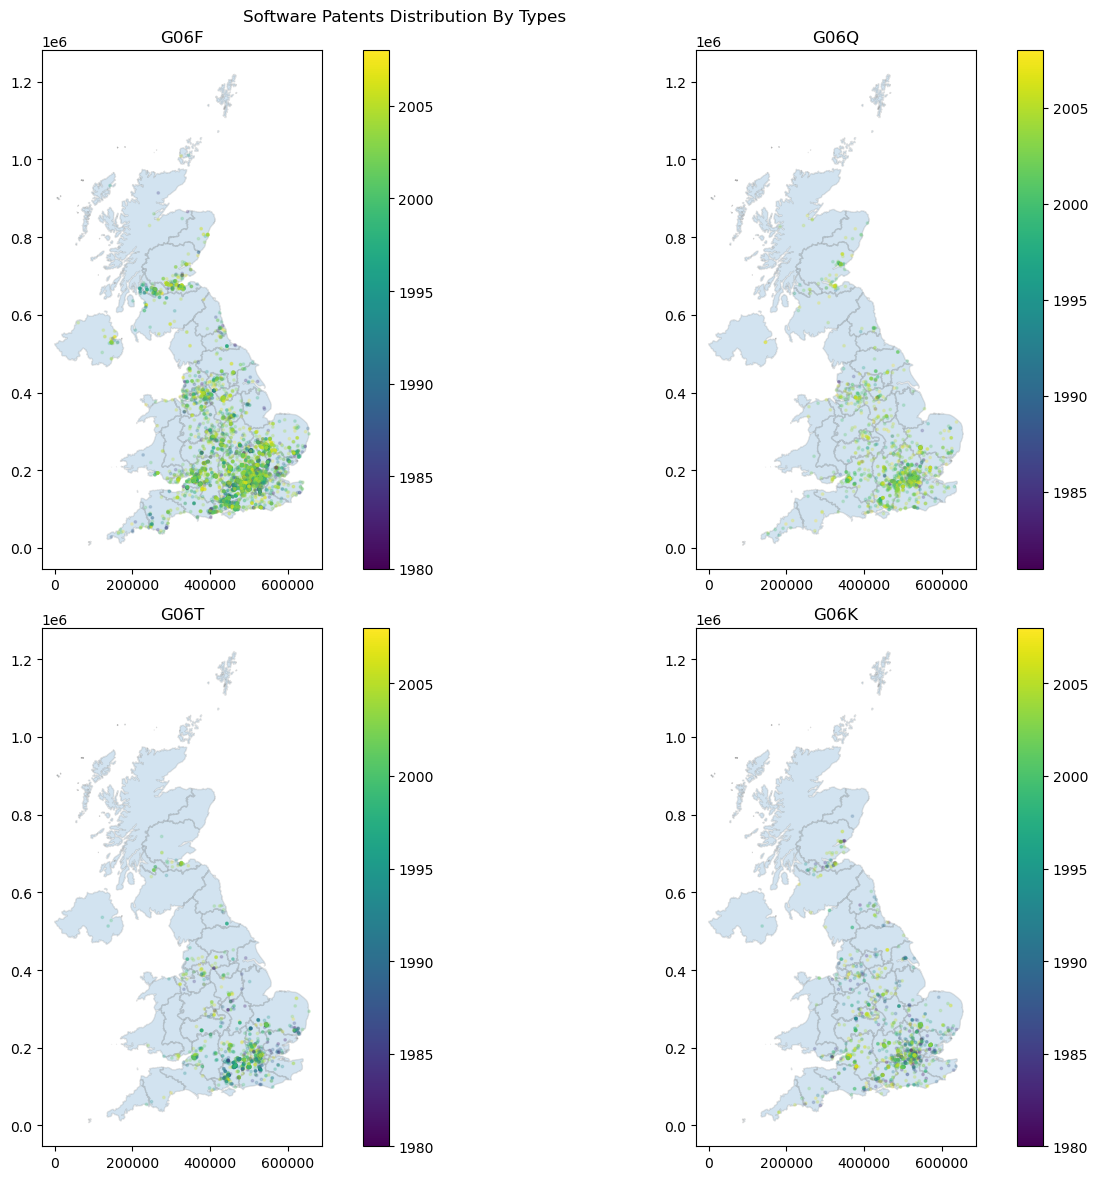

In [607]:
#plot the Boundary data and the gdf_data_G06F, gdf_data_G06Q, gdf_data_G06T, gdf_data_G06K data, based on the crs 27700
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Software Patents Distribution By Types')

Boundary.plot(ax=axs[0, 0], alpha=0.2, edgecolor='grey')
gdf_data_G06F.plot(ax=axs[0, 0], alpha=0.2, legend=True, column='year', markersize=3)
axs[0, 0].set_title('G06F')

Boundary.plot(ax=axs[0, 1], alpha=0.2, edgecolor='grey')
gdf_data_G06Q.plot(ax=axs[0, 1], alpha=0.2, legend=True, column='year', markersize=3)
axs[0, 1].set_title('G06Q')

Boundary.plot(ax=axs[1, 0], alpha=0.2, edgecolor='grey')
gdf_data_G06T.plot(ax=axs[1, 0], alpha=0.2, legend=True, column='year', markersize=3)
axs[1, 0].set_title('G06T')

Boundary.plot(ax=axs[1, 1], alpha=0.2, edgecolor='grey')
gdf_data_G06K.plot(ax=axs[1, 1], alpha=0.2, legend=True, column='year', markersize=3)
axs[1, 1].set_title('G06K')

# tight layout
plt.tight_layout()

plt.show()


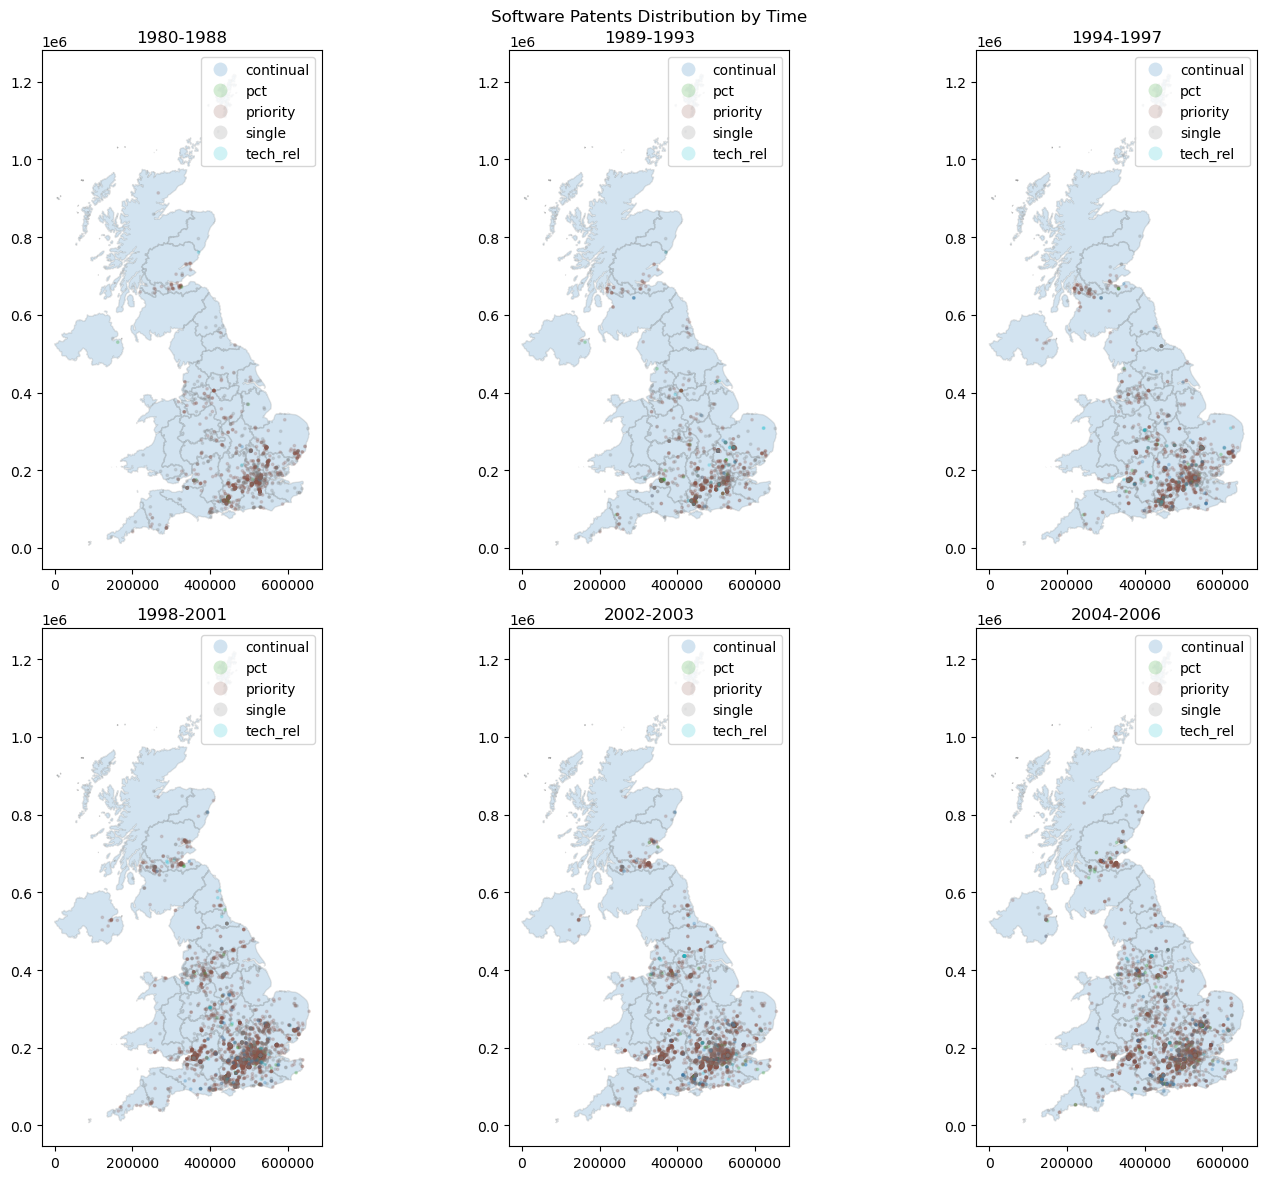

In [608]:
#plot the Boundary data and the gdf_data_G06 data, based on the crs 27700,
# plot six subplots, each for different year period, first from 1980-1988, second from 1989-1993, third from 1994-1997, fourth from 1998-2001, fifth from 2002-2003, sixth from 2004-2006
fig, axs = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Software Patents Distribution by Time')

Boundary.plot(ax=axs[0, 0], alpha=0.2, edgecolor='grey')
gdf_data_G06[gdf_data_G06['year'] <= 1989].plot(ax=axs[0, 0], alpha=0.2, legend=True, column='type', markersize=3)
axs[0, 0].set_title('1980-1988')

Boundary.plot(ax=axs[0, 1], alpha=0.2, edgecolor='grey')
gdf_data_G06[(gdf_data_G06['year'] >= 1988) & (gdf_data_G06['year'] <= 1994)].plot(ax=axs[0, 1], alpha=0.2, legend=True, column='type', markersize=3)
axs[0, 1].set_title('1989-1993')

Boundary.plot(ax=axs[0, 2], alpha=0.2, edgecolor='grey')
gdf_data_G06[(gdf_data_G06['year'] >= 1993) & (gdf_data_G06['year'] <= 1998)].plot(ax=axs[0, 2], alpha=0.2, legend=True, column='type', markersize=3)
axs[0, 2].set_title('1994-1997')

Boundary.plot(ax=axs[1, 0], alpha=0.2, edgecolor='grey')
gdf_data_G06[(gdf_data_G06['year'] >= 1997) & (gdf_data_G06['year'] <= 2002)].plot(ax=axs[1, 0], alpha=0.2, legend=True, column='type', markersize=3)
axs[1, 0].set_title('1998-2001')

Boundary.plot(ax=axs[1, 1], alpha=0.2, edgecolor='grey')
gdf_data_G06[(gdf_data_G06['year'] >= 2001) & (gdf_data_G06['year'] <= 2004)].plot(ax=axs[1, 1], alpha=0.2, legend=True, column='type', markersize=3)
axs[1, 1].set_title('2002-2003')

Boundary.plot(ax=axs[1, 2], alpha=0.2, edgecolor='grey')
gdf_data_G06[gdf_data_G06['year'] >= 2003].plot(ax=axs[1, 2], alpha=0.2, legend=True, column='type', markersize=3)
axs[1, 2].set_title('2004-2006')

# tight layout
plt.tight_layout()

plt.show()


### **3.3 DBSCAN**

In [609]:
# run the dbscan clustering on the gdf_data_G06 data, with the eps=1000, min_samples=10
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


In [610]:
# create new columns 'northing' and 'easting' derived from the 'geometry' column
gdf_data_G06['northing'] = gdf_data_G06.geometry.y
gdf_data_G06['easting'] = gdf_data_G06.geometry.x
gdf_data_G06.sample(5)

appln_id                                      ipc_code patent_office  \
39471   21450326                                      [G06F17]            GB   
16690   17403209  [G06T1, G06T3, G06T7, G06T15, G06T17, H04N1]            EP   
114455  23246875                                      [G06F17]            WO   
34176   21415600                       [A61B5, G06F17, G06F19]            GB   
123048  23697544                                       [G06F1]            WO   

       filing_date        lat      lng          name_0   name_1  \
39471   2004-07-01  53.152699 -1.15132  United Kingdom  England   
16690   1999-07-09  51.501801 -2.57146  United Kingdom  England   
114455  1998-12-16  52.103500  1.31794  United Kingdom  England   
34176   2003-04-29  52.351501 -1.96079  United Kingdom  England   
123048  2006-06-29  53.437302 -1.97338  United Kingdom  England   

                 name_2           name_3             city      type  year  \
39471   Nottinghamshire        Mansfield        Mansfield    single  2004   
16690           Bristol          Bristol          Bristol  priority  1999   
114455          Suffolk  Suffolk coastal  Suffolk coastal  priority  1998   
34176    Worcestershire       Bromsgrove       Bromsgrove  priority  2003   
123048       Derbyshire        High Peak        High Peak       pct  2006   

        month  day                       geometry       northing  \
39471       1    7  POINT (456852.366 362063.396)  362063.396474   
16690       9    7  POINT (360430.678 178251.205)  178251.204816   
114455     12   16  POINT (627323.195 250210.214)  250210.214221   
34176       4   29  POINT (402767.196 272602.784)  272602.784344   
123048      6   29  POINT (401865.677 393390.064)  393390.064485   

              easting  
39471   456852.366000  
16690   360430.677624  
114455  627323.194790  
34176   402767.195821  
123048  401865.676928

In [611]:
gdf_data_G06.sample(5)

appln_id                 ipc_code patent_office filing_date  \
112311  23228977  [G06F13, H04L1, H04L12]            GB  1997-08-12   
42412   21468441                  [G06F3]            GB  2005-03-04   
43504   21474996          [G06F17, H04B3]            GB  2005-06-01   
22087   21323459                 [G06T17]            GB  2000-10-27   
83071   22970674                 [G06F15]            WO  1989-08-03   

              lat       lng          name_0   name_1  \
112311  51.377201 -2.383810  United Kingdom  England   
42412   52.349300 -1.561550  United Kingdom  England   
43504   51.636398 -0.166650  United Kingdom  England   
22087   51.244701 -0.573096  United Kingdom  England   
83071   50.994499 -1.469580  United Kingdom  England   

                              name_2                        name_3  \
112311  Bath and North East Somerset  Bath and North East Somerset   
42412                   Warwickshire                       Warwick   
43504                 Greater London                        Barnet   
22087                         Surrey                     Guildford   
83071                      Hampshire                   Test Valley   

                                city      type  year  month  day  \
112311  Bath and North East Somerset  priority  1997     12    8   
42412                        Warwick    single  2005      4    3   
43504                         London  priority  2005      1    6   
22087                      Guildford  priority  2000     10   27   
83071                    Test Valley       pct  1989      3    8   

                             geometry       northing        easting  
112311  POINT (373382.933 164309.036)  164309.035712  373382.932877  
42412   POINT (429962.005 272447.510)  272447.509506  429962.005451  
43504   POINT (526971.312 194656.719)  194656.719476  526971.312041  
22087   POINT (499693.473 150470.210)  150470.209947  499693.472974  
83071   POINT (437320.483 121812.701)  121812.701262  437320.483427

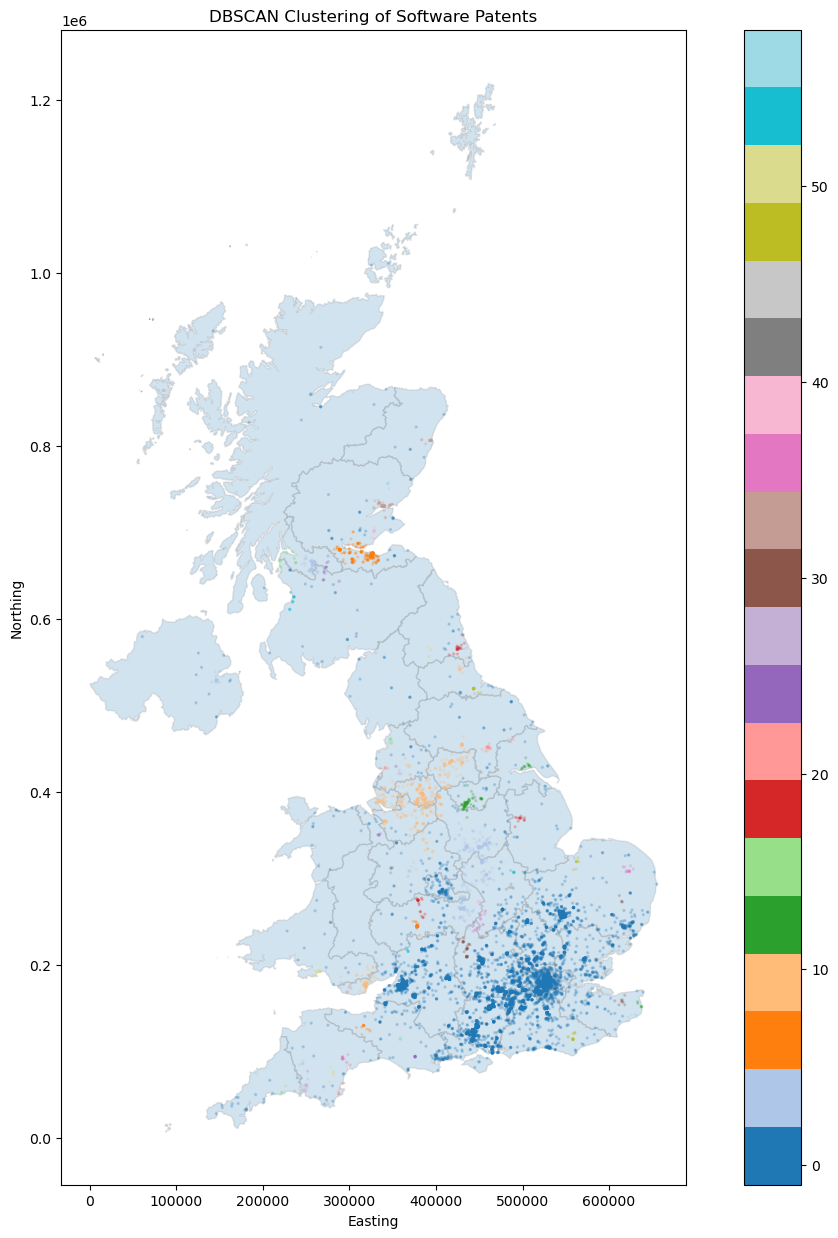

In [612]:
coords = gdf_data_G06[['lat', 'lng']]
coords = StandardScaler().fit_transform(coords)
db = DBSCAN(eps=0.08, min_samples=5).fit(coords)
gdf_data_G06['cluster'] = db.labels_

# plot the Boundary data and the gdf_data_G06 data, based on the crs 4326,
fig, ax = plt.subplots(figsize=(15, 15))
Boundary.plot(ax=ax, alpha=0.2, edgecolor='grey')
# label each boundary with the 'CTYUA23NM' column
#for x, y, label in zip(Boundary.geometry.centroid.x, Boundary.geometry.centroid.y, Boundary['CTYUA23NM']):
   #ax.text(x, y, label, fontsize=5, ha='center')
gdf_data_G06.plot(ax=ax, alpha=0.2, legend=True, column='cluster', cmap='tab20', markersize=2)
# show axis as the northing and easting
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('DBSCAN Clustering of Software Patents')
plt.show()


In [613]:
import geopandas as gpd
from geopandas.tools import sjoin

# Perform a spatial join to match each patent point with the boundary area it falls within
joined = sjoin(gdf_data_G06, Boundary, how='left', op='within')

#  Calculate the number of patents within each boundary area
patent_counts = joined.groupby('index_right').size()

# add the patent number to the Boundary GeoDataFrame
Boundary['patent_number'] = patent_counts

# Fill missing values with 0, as some boundary areas may have no patents
Boundary['patent_number'] = Boundary['patent_number'].fillna(0)

Boundary.sample(5)

/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


nuts218cd                         nuts218nm   bng_e   bng_n     long  \
16      UKG3                     West Midlands  402507  289715 -1.96448   
40      UKN0                  Northern Ireland   86601  535325 -6.85481   
36      UKM6             Highlands and Islands  251287  833327 -4.47425   
1       UKC2  Northumberland and Tyne and Wear  398898  602530 -2.01892   
37      UKM7                  Eastern Scotland  300521  733779 -3.61698   

          lat                              GlobalID  \
16  52.505341  dae1aa6d-284e-4e1a-b5f9-10ed2bec35b6   
40  54.614941  9e5ac0a5-38a1-4d13-8570-c19583a4a0c8   
36  57.366032  5f809fb6-0531-409a-8d03-81f5e49ee02c   
1   55.316841  820428b9-d7c5-4407-a1e2-6df1d53b8a55   
37  56.485550  7aead0aa-a7db-45cb-99a1-d145763c9f19   

                                             geometry  patent_number  
16  POLYGON ((403169.303 307212.800, 403789.900 30...            111  
40  MULTIPOLYGON (((116908.519 602925.239, 119760....             34  
36  MULTIPOLYGON (((320000.017 976689.515, 320250....             14  
1   MULTIPOLYGON (((397942.931 657535.008, 400000....             40  
37  POLYGON ((345866.000 788757.500, 348358.500 78...            330

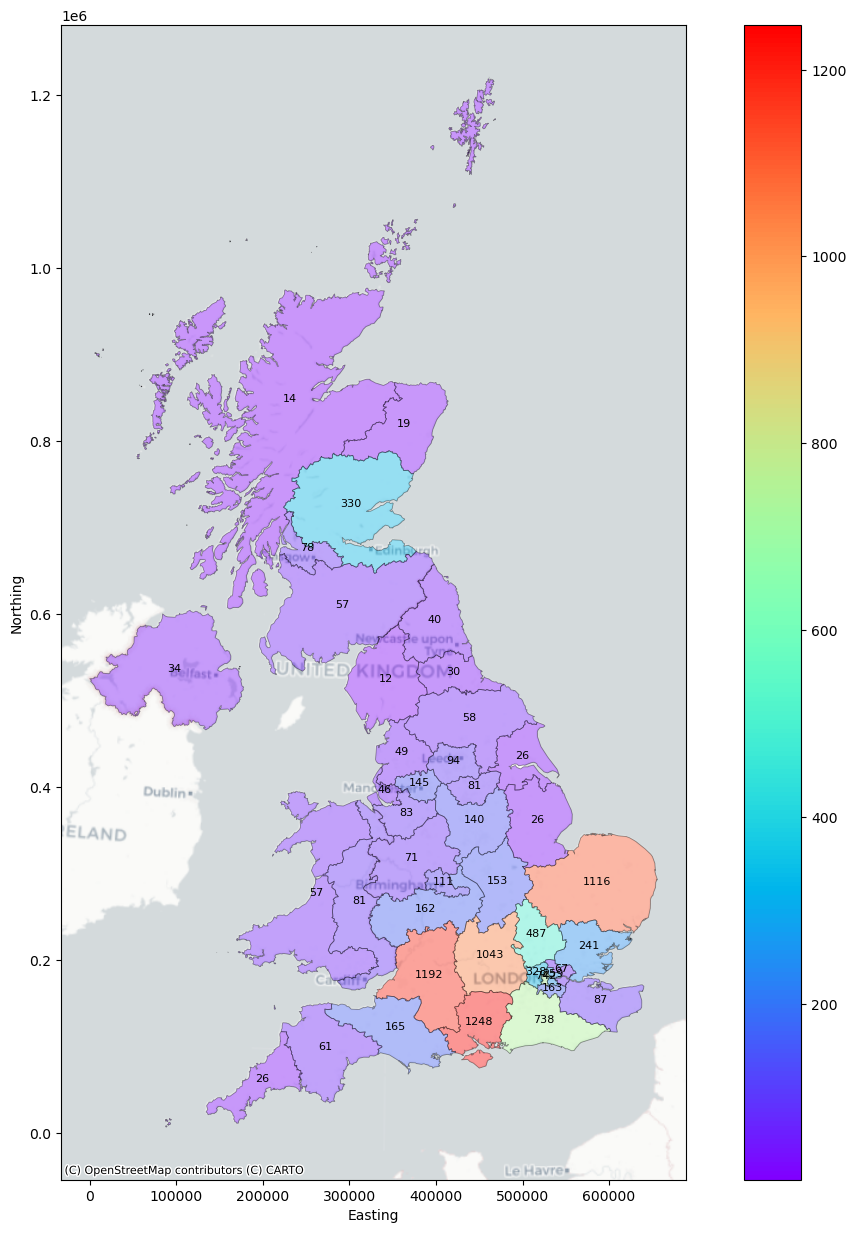

In [614]:
# plot the Boundary data and the gdf_data_G06 data, based on the crs 4326,
fig, ax = plt.subplots(figsize=(15, 15))
# color each boundary based on  the 'patent_number' column
Boundary.plot(ax=ax, alpha=0.4, legend=True, column='patent_number', cmap='rainbow', edgecolor='black', linewidth=0.6)
#label each boundary with the 'patent_number' column
for x, y, label in zip(Boundary.geometry.centroid.x, Boundary.geometry.centroid.y, Boundary['patent_number']):
    ax.text(x, y, int(label), fontsize=8, ha='center')

# add the basemap with osm
    
ctx.add_basemap(ax, crs=Boundary.crs, source=ctx.providers.CartoDB.Positron)

#gdf_data_G06.plot(ax=ax, alpha=0.2, legend=True, column='cluster', cmap='viridis', markersize=2)
# show axis as the northing and easting
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

## **3. Breakthrough Innovation**
### 3.1 Using distinctive cpc_code pair find the breakthrough innovation

In [615]:
# run the co-occurrence analysis for the ipc_code column
from itertools import combinations
from collections import Counter

# create a list of all ipc_code in the data
ipc_list = gdf_data_G06['ipc_code'].tolist()

# create a list of all combinations of 2 ipc_code in the data
ipc_combinations = [list(combinations(x, 2)) for x in ipc_list]
ipc_combinations = [item for sublist in ipc_combinations for item in sublist]

# count the number of each combination
ipc_combinations_count = Counter(ipc_combinations)

# create a dataframe from the dictionary of the combination count
df_ipc_combinations_count = pd.DataFrame.from_dict(ipc_combinations_count, orient='index').reset_index()
df_ipc_combinations_count.columns = ['ipc_combinations', 'count']
df_ipc_combinations_count = df_ipc_combinations_count.sort_values(by='count', ascending=False)
df_ipc_combinations_count.head(10)

ipc_combinations  count
266    (G06F9, G06F15)    245
29     (G06F1, G06F21)    235
291    (G06F21, H04L9)    157
239   (G06F12, G06F13)    153
243   (G06F13, G06F15)    151
179   (G06F21, H04L29)    150
173    (G06F9, G06F17)    148
1120   (G06F7, G06F17)    145
265    (G06F3, G06F17)    142
172    (G06F9, G06F13)    137

In [616]:
# filter out the top 10 most common combinations
top_10_combinations = df_ipc_combinations_count.head(200)['ipc_combinations'].tolist()

# check the gdf_data_G06 dataframe, for each row, if the list of ipc_code column contains any of the top 10 combinations
# if yes, delete the row, if no, remain the row
breakthrough = gdf_data_G06[~gdf_data_G06['ipc_code'].apply(lambda x: any(set(i).issubset(set(x)) for i in top_10_combinations))]

# delete all rows with only one element in the ipc_code column
breakthrough = breakthrough[breakthrough['ipc_code'].apply(lambda x: len(x) > 1)]

# check the shape of the new dataframe
print(breakthrough.shape)

(2069, 19)


In [617]:
# Create a 'decade' column
gdf_data_G06['decade'] = gdf_data_G06['year'].apply(lambda x: x - x % 10)

# Filter rows where 'ipc_code' has only one element
df_single_ipc = gdf_data_G06[gdf_data_G06['ipc_code'].apply(lambda x: len(x) == 1)]

# Flatten 'ipc_code' lists and keep only the first occurrence in each decade
df_single_ipc['ipc_code'] = df_single_ipc['ipc_code'].apply(lambda x: x[0])
df_single_ipc = df_single_ipc.drop_duplicates(subset=['decade', 'ipc_code'])

/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [618]:
# add df_single_ipc to the breakthrough dataframe
breakthrough = pd.concat([breakthrough, df_single_ipc])

breakthrough.shape

(2195, 20)

In [619]:
# use the association rule mining to find the most common association between ipc_code
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# create a dataframe with the ipc_code column as the index and the appln_id column as the value
df_ipc = gdf_data_G06.set_index('appln_id')['ipc_code'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(name='ipc_code')
df_ipc = df_ipc.drop_duplicates()

# create a one-hot encoded dataframe
df_ipc_onehot = pd.get_dummies(df_ipc['ipc_code']).groupby(df_ipc['appln_id']).sum()

# run the apriori algorithm
frequent_itemsets = apriori(df_ipc_onehot, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
rules = rules.sort_values(by='confidence', ascending=False)

rules.head(10)

/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


antecedents consequents  antecedent support  consequent support   support  \
19     (G06T9)     (H04N7)            0.018754            0.041320  0.013238   
14     (H04L9)    (G06F21)            0.025273            0.066192  0.015746   
16     (G09G5)     (G06F3)            0.022365            0.131882  0.013038   
18     (G07F7)    (G06Q20)            0.025073            0.026176  0.010932   
17    (G06Q20)     (G07F7)            0.026176            0.025073  0.010932   
1     (G06F21)     (G06F1)            0.066192            0.079932  0.023568   
23     (H04N5)     (H04N7)            0.033999            0.041320  0.011834   
10     (G06F7)    (G06F17)            0.043025            0.189349  0.014542   
20     (H04N7)     (G06T9)            0.041320            0.018754  0.013238   
12    (H04L29)    (G06F21)            0.047438            0.066192  0.015044   

    confidence       lift  leverage  conviction  zhangs_metric  
19    0.705882  17.083381  0.012463    3.259513       0.959458  
14    0.623016   9.412259  0.014073    2.477049       0.916929  
16    0.582960   4.420297  0.010088    2.081615       0.791472  
18    0.436000  16.656536  0.010275    1.726638       0.964137  
17    0.417625  16.656536  0.010275    1.674053       0.965229  
1     0.356061   4.454555  0.018278    1.428812       0.830482  
23    0.348083   8.424106  0.010430    1.470555       0.912310  
10    0.337995   1.785038  0.006395    1.224540       0.459560  
20    0.320388  17.083381  0.012463    1.443833       0.982041  
12    0.317125   4.790986  0.011904    1.367465       0.830680

### 3.2 EDA of Breakthrough Innovation

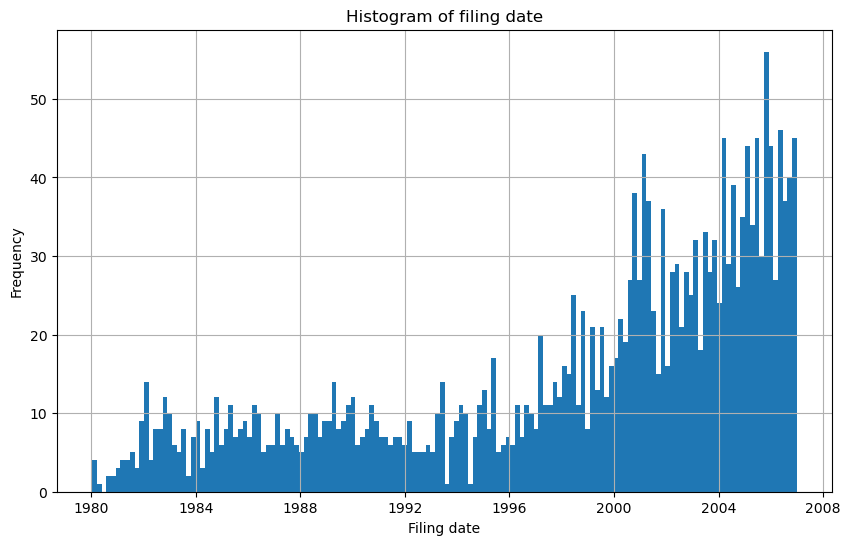

In [620]:
# plot the histogram based on the date time
fig, ax = plt.subplots(figsize=(10, 6))
breakthrough['filing_date'].hist(bins=150, ax=ax)
ax.set_title('Histogram of filing date')
ax.set_xlabel('Filing date')
ax.set_ylabel('Frequency')
plt.show()

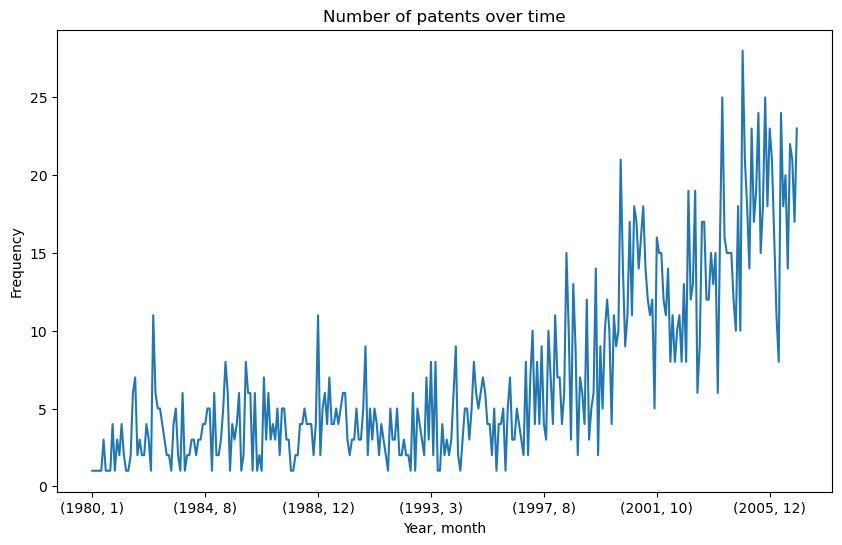

In [621]:
# plot the line graph based on the date time, only refer to the year and month, not the day
fig, ax = plt.subplots(figsize=(10, 6))
breakthrough.groupby(['year', 'month']).size().plot(ax=ax)
ax.set_title('Number of patents over time')
# set the x-axis label to be the year and month
ax.set_xlabel('Year, month')
ax.set_ylabel('Frequency')
plt.show()

**Breakthrough Innovations by Cities over Time**

In [622]:
# print how many unique values in the 'city' column
print(f"There are {breakthrough['city'].nunique()} unique values in the 'city' column, meaning there are {gdf_data_G06['city'].nunique()} cities in the data")

There are 280 unique values in the 'city' column, meaning there are 343 cities in the data


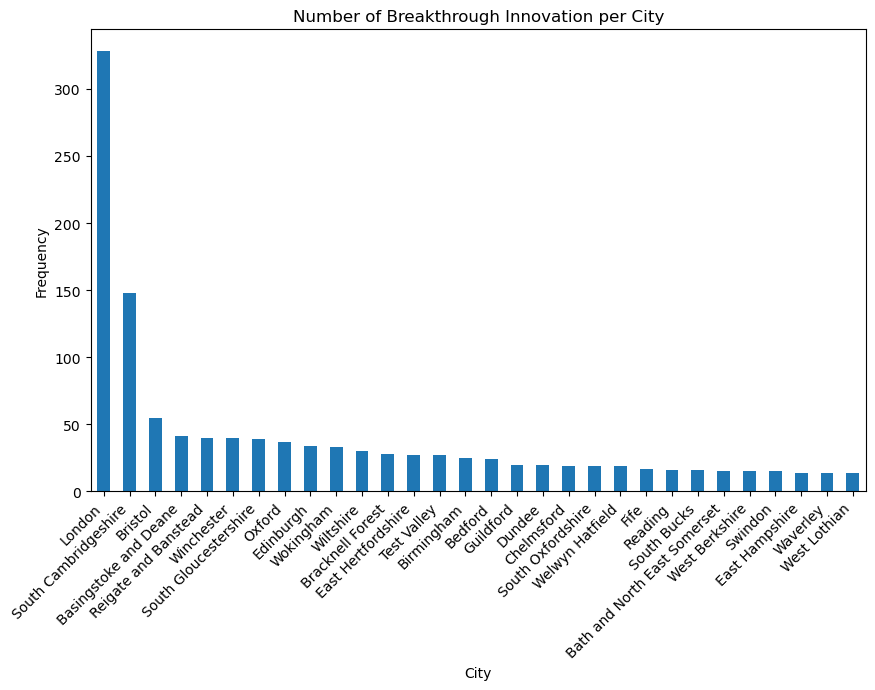

In [623]:
# plot and set the x label as 45 degree with right alignment

fig, ax = plt.subplots(figsize=(10, 6))
breakthrough['city'].value_counts().head(30).plot(kind='bar', ax=ax)
ax.set_title('Number of Breakthrough Innovation per City')
ax.set_xlabel('City')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [624]:
# check top 1%(1st to 3rd), top 5%(4th to 17th), everywhere else's cities name for number of patents.

# top 1, top 2, top 3
top_1_b = breakthrough['city'].value_counts().head(1).index.to_list()
top_2_b = breakthrough['city'].value_counts().iloc[1:2].index.to_list()
top_3_b = breakthrough['city'].value_counts().iloc[2:3].index.to_list()
# top 4 to top 17
top_5percent_b = breakthrough['city'].value_counts().iloc[3:17].index.to_list()
# the rest
the_rest_b = breakthrough['city'].value_counts().iloc[17:].index.to_list()


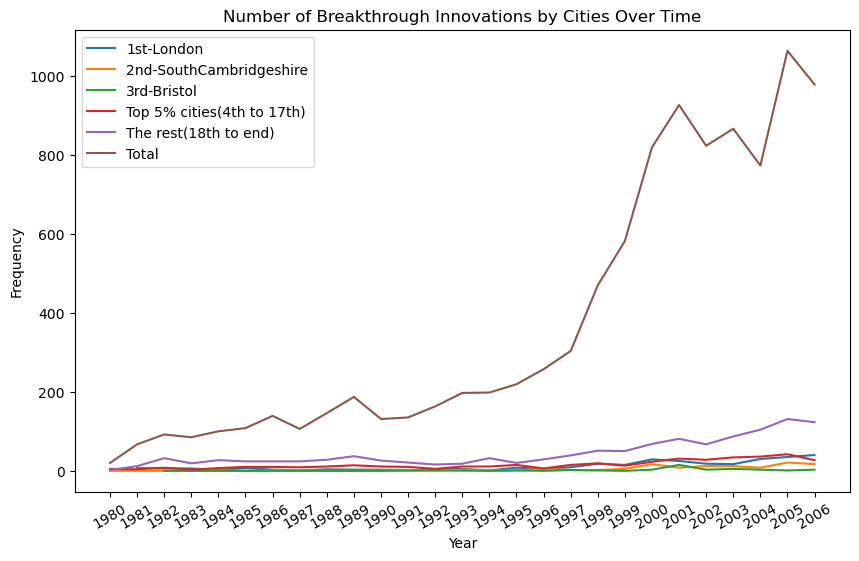

In [625]:
# plot the line graph for top1, top2, top3, top5 and the rest seperately, based on their number of patents over time
fig, ax = plt.subplots(figsize=(10, 6))
breakthrough[breakthrough['city'].isin(top_1_b)].groupby('year').size().plot(ax=ax, label='1st-London')
breakthrough[breakthrough['city'].isin(top_2_b)].groupby('year').size().plot(ax=ax, label='2nd-SouthCambridgeshire')
breakthrough[breakthrough['city'].isin(top_3_b)].groupby('year').size().plot(ax=ax, label='3rd-Bristol')
breakthrough[breakthrough['city'].isin(top_5percent_b)].groupby('year').size().plot(ax=ax, label='Top 5% cities(4th to 17th)')
breakthrough[breakthrough['city'].isin(the_rest_b)].groupby('year').size().plot(ax=ax, label='The rest(18th to end)')
# plot the total number of patents over time
gdf_data_G06.groupby('year').size().plot(ax=ax, label='Total')
ax.set_title('Number of Breakthrough Innovations by Cities Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_xticks(breakthrough['year'].unique())  # Set the x-ticks to be all unique years in the data
ax.set_xticklabels(breakthrough['year'].unique(), rotation=30)  # Rotate labels if needed for better readability

plt.legend()
plt.show()

### 3.3 Geoinfo of Breakthrough Innovation

In [626]:
# import the shpaefile data
Boundary_1 = gpd.read_file('data/Boundary/NUTS2_Jan_2018_UGCB_in_the_UK.shp')
# set the crs to the 27700
Boundary_1 =Boundary_1.to_crs(epsg=27700)
# set the crs of the gdf_data_G06 to the crs of the Boundary
breakthrough = breakthrough.to_crs(Boundary_1.crs)


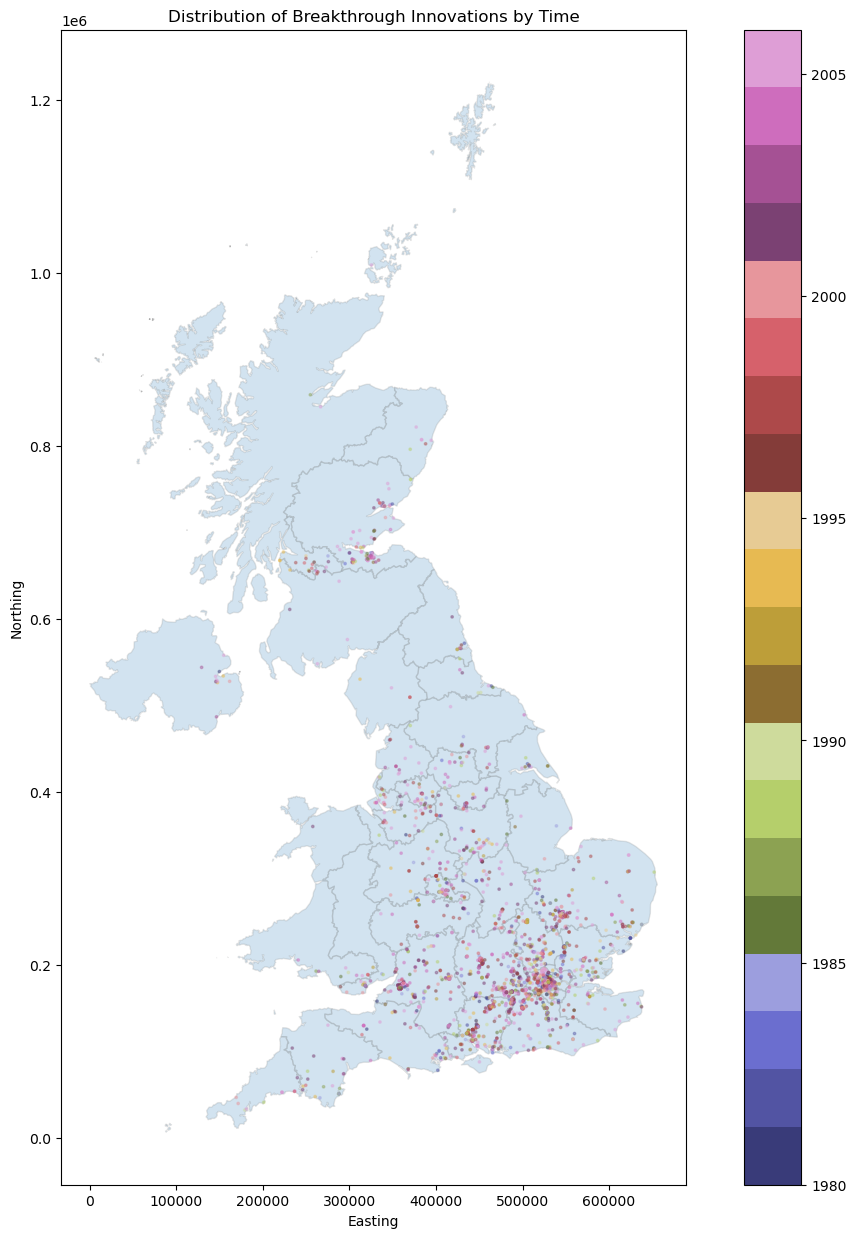

In [627]:
# plot the Boundary data and the breakthrough data, based on the crs 4326,
fig, ax = plt.subplots(figsize=(15, 15))
Boundary_1.plot(ax=ax, alpha=0.2, edgecolor='grey')
# label each boundary with the 'CTYUA23NM' column
#for x, y, label in zip(Boundary.geometry.centroid.x, Boundary.geometry.centroid.y, Boundary['CTYUA23NM']):
   #ax.text(x, y, label, fontsize=5, ha='center')
breakthrough.plot(ax=ax, alpha=0.4, legend=True, column='year', cmap='tab20b', markersize=3)
# show axis as the northing and easting
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('Distribution of Breakthrough Innovations by Time')
plt.show()


/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


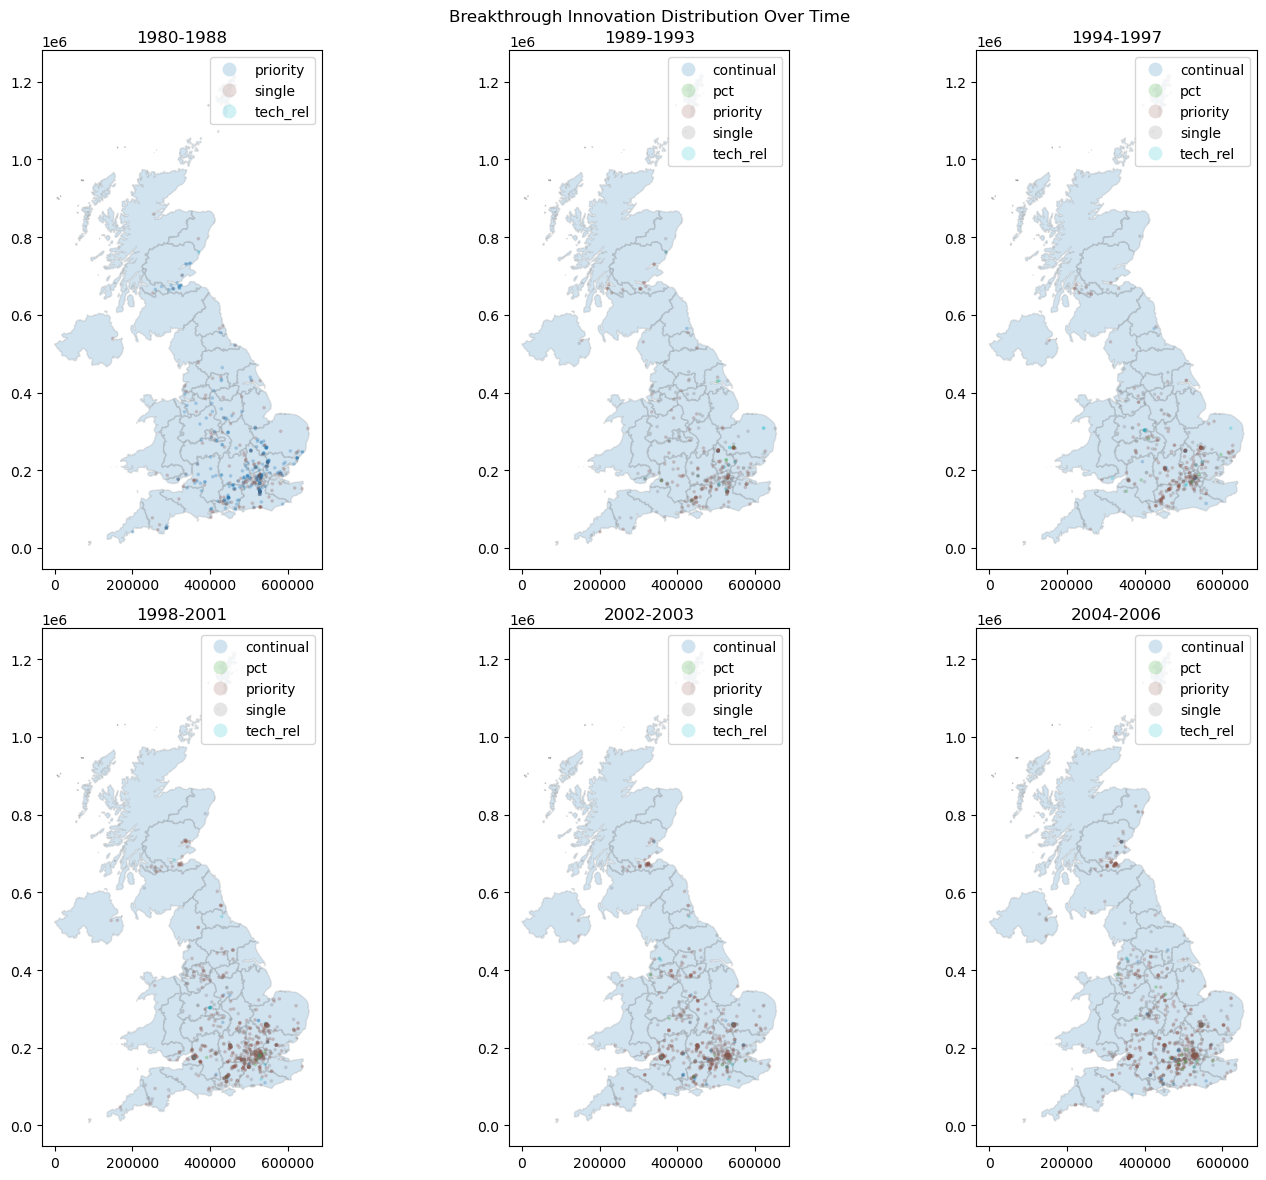

In [628]:
#plot the Boundary data and the gdf_data_G06 data, based on the crs 27700,
# plot six subplots, each for different year period, first from 1980-1988, second from 1989-1993, third from 1994-1997, fourth from 1998-2001, fifth from 2002-2003, sixth from 2004-2006
fig, axs = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Breakthrough Innovation Distribution Over Time')

Boundary_1.plot(ax=axs[0, 0], alpha=0.2, edgecolor='grey')
breakthrough[breakthrough['year'] <= 1989].plot(ax=axs[0, 0], alpha=0.2, legend=True, column='type', markersize=3)
axs[0, 0].set_title('1980-1988')

Boundary_1.plot(ax=axs[0, 1], alpha=0.2, edgecolor='grey')
breakthrough[(breakthrough['year'] >= 1988) & (gdf_data_G06['year'] <= 1994)].plot(ax=axs[0, 1], alpha=0.2, legend=True, column='type', markersize=3)
axs[0, 1].set_title('1989-1993')

Boundary_1.plot(ax=axs[0, 2], alpha=0.2, edgecolor='grey')
breakthrough[(breakthrough['year'] >= 1993) & (gdf_data_G06['year'] <= 1998)].plot(ax=axs[0, 2], alpha=0.2, legend=True, column='type', markersize=3)
axs[0, 2].set_title('1994-1997')

Boundary_1.plot(ax=axs[1, 0], alpha=0.2, edgecolor='grey')
breakthrough[(breakthrough['year'] >= 1997) & (gdf_data_G06['year'] <= 2002)].plot(ax=axs[1, 0], alpha=0.2, legend=True, column='type', markersize=3)
axs[1, 0].set_title('1998-2001')

Boundary_1.plot(ax=axs[1, 1], alpha=0.2, edgecolor='grey')
breakthrough[(breakthrough['year'] >= 2001) & (gdf_data_G06['year'] <= 2004)].plot(ax=axs[1, 1], alpha=0.2, legend=True, column='type', markersize=3)
axs[1, 1].set_title('2002-2003')

Boundary_1.plot(ax=axs[1, 2], alpha=0.2, edgecolor='grey')
breakthrough[breakthrough['year'] >= 2003].plot(ax=axs[1, 2], alpha=0.2, legend=True, column='type', markersize=3)
axs[1, 2].set_title('2004-2006')

# tight layout
plt.tight_layout()

plt.show()

### 3.4 DBSCAN


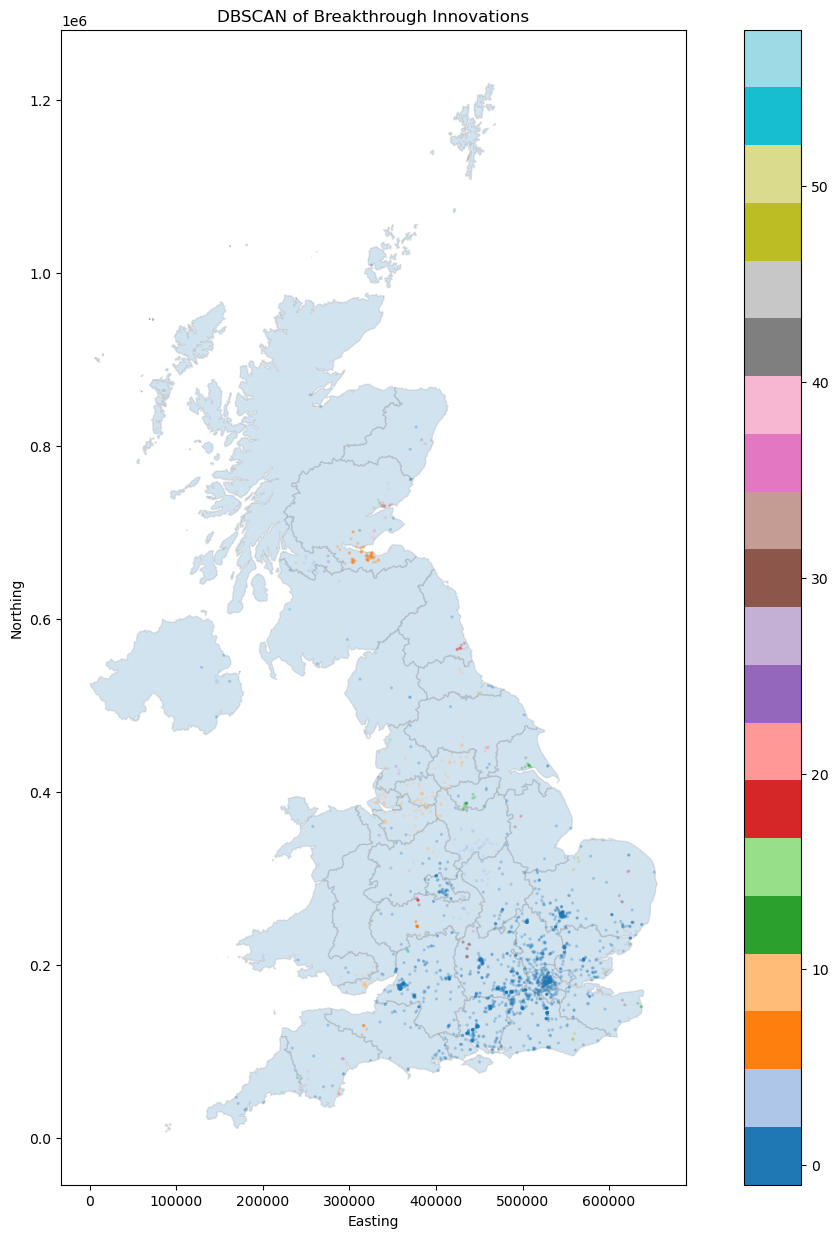

In [629]:
coords = breakthrough[['lat', 'lng']]
coords = StandardScaler().fit_transform(coords)
db = DBSCAN(eps=0.08, min_samples=5).fit(coords)
breakthrough['cluster_1'] = db.labels_

# plot the Boundary data and the gdf_data_G06 data, based on the crs 4326,
fig, ax = plt.subplots(figsize=(15, 15))
Boundary_1.plot(ax=ax, alpha=0.2, edgecolor='grey')
# label each boundary with the 'CTYUA23NM' column
#for x, y, label in zip(Boundary.geometry.centroid.x, Boundary.geometry.centroid.y, Boundary['CTYUA23NM']):
   #ax.text(x, y, label, fontsize=5, ha='center')
breakthrough.plot(ax=ax, alpha=0.2, legend=True, column='cluster', cmap='tab20', markersize=2)
# show axis as the northing and easting
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('DBSCAN of Breakthrough Innovations')
plt.show()

In [630]:
# Perform a spatial join to match each patent point with the boundary area it falls within
joined_1 = sjoin(breakthrough, Boundary_1, how='left', op='within')

#  Calculate the number of patents within each boundary area
patent_counts_1 = joined_1.groupby('index_right').size()

# add the patent number to the Boundary GeoDataFrame
Boundary_1['patent_number_1'] = patent_counts_1

# Fill missing values with 0, as some boundary areas may have no patents
Boundary_1['patent_number_1'] = Boundary_1['patent_number_1'].fillna(0)

Boundary_1.sample(5)

/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


nuts218cd                     nuts218nm   bng_e   bng_n     long  \
31      UKK3  Cornwall and Isles of Scilly  212501   64494 -4.64249   
40      UKN0              Northern Ireland   86601  535325 -6.85481   
21      UKI4           Inner London - East  536648  185058 -0.03064   
0       UKC1        Tees Valley and Durham  414643  532242 -1.77440   
26      UKJ2  Surrey, East and West Sussex  527932  133940 -0.17460   

          lat                              GlobalID  \
31  50.450230  7ce71797-d82b-4fe2-b94b-bc96d83f395d   
40  54.614941  9e5ac0a5-38a1-4d13-8570-c19583a4a0c8   
21  51.547871  3d259d86-16e7-4b70-99c7-0694bb74a50e   
0   54.685020  8b5639bc-fc77-466e-ab84-5298b72cd941   
26  51.090511  e8b04f76-ec58-44e0-84ab-b6257cde501b   

                                             geometry  patent_number_1  
31  MULTIPOLYGON (((229169.697 98911.096, 230214.0...               10  
40  MULTIPOLYGON (((116908.519 602925.239, 119760....               11  
21  MULTIPOLYGON (((535728.596 191460.904, 534444....               56  
0   POLYGON ((417008.003 558240.105, 417736.396 55...                7  
26  MULTIPOLYGON (((486959.850 134505.300, 487664....              187

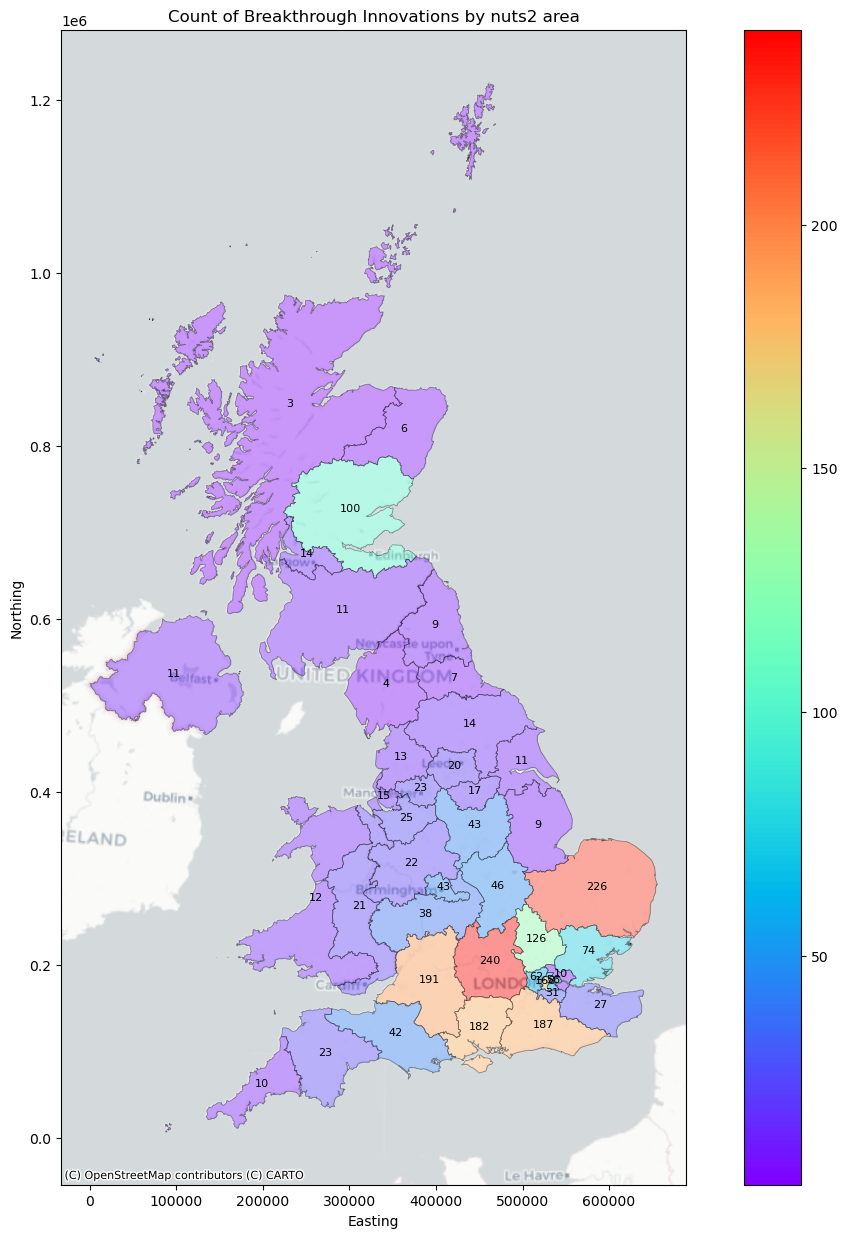

In [631]:
# plot the Boundary data and the gdf_data_G06 data, based on the crs 4326,
fig, ax = plt.subplots(figsize=(15, 15))
# color each boundary based on  the 'patent_number' column
Boundary_1.plot(ax=ax, alpha=0.4, legend=True, column='patent_number_1', cmap='rainbow', edgecolor='black', linewidth=0.6)
#label each boundary with the 'patent_number' column
for x, y, label in zip(Boundary_1.geometry.centroid.x, Boundary_1.geometry.centroid.y, Boundary_1['patent_number_1']):
    ax.text(x, y, int(label), fontsize=8, ha='center')

# add the basemap with osm
    
ctx.add_basemap(ax, crs=Boundary.crs, source=ctx.providers.CartoDB.Positron)

#gdf_data_G06.plot(ax=ax, alpha=0.2, legend=True, column='cluster', cmap='viridis', markersize=2)
# show axis as the northing and easting
ax.set
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('Count of Breakthrough Innovations by nuts2 area')
plt.show()

## **4. Regression Preparation**

**Create the Dataframe with LADs and Years as index**

In [632]:
# import the shpaefile data
Boundary = gpd.read_file('data/Boundary/NUTS2_Jan_2018_UGCB_in_the_UK.shp')
# set the crs to the 27700
Boundary = Boundary.to_crs(epsg=27700)
# set the crs of the gdf_data_G06 to the crs of the Boundary
breakthrough = breakthrough.to_crs(Boundary.crs)


In [633]:
# extract the 'nuts118nm','nuts118cd' column from the Boundary data
Boundary2 = Boundary[['nuts218cd', 'nuts218nm', 'geometry']]

# Create a DataFrame with years
years = np.arange(1980, 2007)
Boundary_years = pd.DataFrame({'year': np.tile(years, len(Boundary2))})

# Repeat the rows of Boundary2 to match the number of years
Boundary2_repeated = Boundary2.loc[Boundary2.index.repeat(len(years))].reset_index(drop=True)

# Merge the year DataFrame with the repeated Boundary2 DataFrame
Boundary2_with_years = pd.concat([Boundary2_repeated, Boundary_years], axis=1)

# Convert the result to a GeoDataFrame
Boundary2_with_years = gpd.GeoDataFrame(Boundary2_with_years, geometry='geometry')
Boundary2_with_years.sample(2)

nuts218cd                           nuts218nm  \
1010      UKM7                    Eastern Scotland   
649       UKI7  Outer London - West and North West   

                                               geometry  year  
1010  POLYGON ((345866.000 788757.500, 348358.500 78...  1991  
649   POLYGON ((524339.298 198344.404, 525206.002 19...  1981

In [634]:
# Perform a spatial join to match each patent point with the boundary area it falls within, also make sure the 'year' column of the patent points matches the 'year' column of the boundary areas
spatial_joined = sjoin(breakthrough, Boundary2_with_years, how='left', op='within')

# Filter the resulting joined data to ensure the 'year' columns match
matched = spatial_joined[spatial_joined['year_left'] == spatial_joined['year_right']]

# Delete the extra 'year_right' column and rename the 'year_left' column to 'year'
matched = matched.drop(columns=['year_right']).rename(columns={'year_left': 'year'})

/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [635]:
matched.sample(2)

appln_id                        ipc_code patent_office filing_date  \
78976   22934297          [A01K61, G06M1, G06M7]            GB  1987-11-23   
120611  23292705  [B41J2, B41J29, G06K15, H04N1]            GB  1999-07-17   

              lat       lng          name_0    name_1         name_2  \
78976   57.598999 -4.431200  United Kingdom  Scotland       Highland   
120611  51.755100 -0.298954  United Kingdom   England  Hertfordshire   

              name_3  ... day                       geometry       northing  \
78976       Highland  ...  23  POINT (254804.125 859159.449)  859159.448796   
120611  Saint Albans  ...  17  POINT (517508.452 207635.706)  207635.706065   

              easting  cluster decade  cluster_1  index_right  nuts218cd  \
78976   254804.125229       -1    NaN         -1        979.0       UKM6   
120611  517508.452192        1    NaN          0        505.0       UKH2   

                             nuts218nm  
78976            Highlands and Islands  
120611  Bedfordshire and Hertfordshire  

[2 rows x 24 columns]

In [636]:
import itertools

In [637]:
patent_counts_df = pd.DataFrame(list(itertools.product(Boundary2['nuts218cd'], years)), columns=['nuts218cd', 'year'])
# only keep the year after 1997
patent_counts_df = patent_counts_df[patent_counts_df['year'] > 1997]

In [638]:

# Calculate the number of patents within each boundary area for each year
patent_counts = matched.groupby(['year', 'nuts218cd', 'nuts218nm']).size()


# Convert patent_counts to a DataFrame
patent_counts_df2 = patent_counts.reset_index()
patent_counts_df2

year nuts218cd                                   nuts218nm   0
0    1980      UKH1                                 East Anglia   1
1    1980      UKJ1  Berkshire, Buckinghamshire and Oxfordshire   1
2    1980      UKJ2                Surrey, East and West Sussex   3
3    1980      UKJ3                 Hampshire and Isle of Wight   4
4    1980      UKL2                                  East Wales   1
..    ...       ...                                         ...  ..
587  2006      UKM5                      North Eastern Scotland   2
588  2006      UKM6                       Highlands and Islands   2
589  2006      UKM7                            Eastern Scotland  15
590  2006      UKM9                           Southern Scotland   3
591  2006      UKN0                            Northern Ireland   2

[592 rows x 4 columns]

In [639]:
patent_counts_df2.columns = ['year', 'nuts218cd', 'nuts218nm', 'patent_number']

# merge the patent_counts with the patent_counts_df by the column 'year' and 'nuts218cd'
# remain the 'patent_number' column from the patent_counts_df2
patent_counts_df = pd.merge(patent_counts_df, patent_counts_df2, on=['year', 'nuts218cd'], how='left')
# Fill missing values with 0, as some boundary areas may have no patents
patent_counts_df['patent_number'] = patent_counts_df['patent_number'].fillna(0)
# generate a 'nuts218nm' towards the 'nuts218cd' column as a dictionary
# and fill the missing values with the 'nuts218nm' column in the patent_counts_df based on this dictionary
nuts218nm_dict = Boundary2.set_index('nuts218cd')['nuts218nm'].to_dict()
patent_counts_df['nuts218nm'] = patent_counts_df['nuts218cd'].map(nuts218nm_dict)

patent_counts_df

nuts218cd  year               nuts218nm  patent_number
0        UKC1  1998  Tees Valley and Durham            0.0
1        UKC1  1999  Tees Valley and Durham            0.0
2        UKC1  2000  Tees Valley and Durham            0.0
3        UKC1  2001  Tees Valley and Durham            1.0
4        UKC1  2002  Tees Valley and Durham            0.0
..        ...   ...                     ...            ...
364      UKN0  2002        Northern Ireland            0.0
365      UKN0  2003        Northern Ireland            2.0
366      UKN0  2004        Northern Ireland            0.0
367      UKN0  2005        Northern Ireland            2.0
368      UKN0  2006        Northern Ireland            2.0

[369 rows x 4 columns]

In [640]:
patent_counts_df.shape

(369, 4)

In [641]:
# remove all the year before 1998
patent_counts_df = patent_counts_df[patent_counts_df['year'] >= 1998]

patent_counts_df.shape

(369, 4)

### 4.1 GDP

the dataset is from: https://www.ons.gov.uk/datasets/gdp-by-local-authority/editions/time-series/versions/2

https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/regionalgrossdomesticproductallnutslevelregions

In [642]:
# Load the GDP data
gdp_data = pd.read_csv('data/control_data/gdp_by_nuts2.csv')


In [643]:
# Reshape the GDP DataFrame from wide format to long format
gdp_data_long = pd.melt(gdp_data, id_vars=['ITL code', 'Region name'], var_name='year', value_name='gdp')

# Convert the 'year' column to numeric
gdp_data_long['year'] = pd.to_numeric(gdp_data_long['year'], errors='coerce')

# Drop rows with NaN values in the 'year' column
gdp_data_long = gdp_data_long.dropna(subset=['year'])

# Convert the 'year' column to numeric
gdp_data_long['year'] = pd.to_numeric(gdp_data_long['year'])

gdp_data_long.sample(5)

# rename the region name column to nuts218nm
gdp_data_long = gdp_data_long.rename(columns={'ITL code': 'nuts218cd'})


In [644]:
# convert the gdps to float
gdp_data_long['gdp'] = gdp_data_long['gdp'].str.replace(',', '').astype(float)

In [645]:
# Merge the DataFrames
patent_counts_df = pd.merge(patent_counts_df, gdp_data_long, how='left', on=['nuts218cd', 'year'])

In [646]:
patent_counts_df.shape

(369, 6)

In [647]:
patent_counts_df

nuts218cd  year               nuts218nm  patent_number  \
0        UKC1  1998  Tees Valley and Durham            0.0   
1        UKC1  1999  Tees Valley and Durham            0.0   
2        UKC1  2000  Tees Valley and Durham            0.0   
3        UKC1  2001  Tees Valley and Durham            1.0   
4        UKC1  2002  Tees Valley and Durham            0.0   
..        ...   ...                     ...            ...   
364      UKN0  2002        Northern Ireland            0.0   
365      UKN0  2003        Northern Ireland            2.0   
366      UKN0  2004        Northern Ireland            0.0   
367      UKN0  2005        Northern Ireland            2.0   
368      UKN0  2006        Northern Ireland            2.0   

                Region name      gdp  
0    Tees Valley and Durham  12210.0  
1    Tees Valley and Durham  12708.0  
2    Tees Valley and Durham  13130.0  
3    Tees Valley and Durham  13365.0  
4    Tees Valley and Durham  14061.0  
..                      ...      ...  
364        Northern Ireland  24045.0  
365        Northern Ireland  25966.0  
366        Northern Ireland  27241.0  
367        Northern Ireland  28755.0  
368        Northern Ireland  30496.0  

[369 rows x 6 columns]

In [648]:
# convert the 'gdp' column to numeric
patent_counts_df['gdp'] = pd.to_numeric(patent_counts_df['gdp'], errors='coerce')

In [649]:
patent_counts_df

nuts218cd  year               nuts218nm  patent_number  \
0        UKC1  1998  Tees Valley and Durham            0.0   
1        UKC1  1999  Tees Valley and Durham            0.0   
2        UKC1  2000  Tees Valley and Durham            0.0   
3        UKC1  2001  Tees Valley and Durham            1.0   
4        UKC1  2002  Tees Valley and Durham            0.0   
..        ...   ...                     ...            ...   
364      UKN0  2002        Northern Ireland            0.0   
365      UKN0  2003        Northern Ireland            2.0   
366      UKN0  2004        Northern Ireland            0.0   
367      UKN0  2005        Northern Ireland            2.0   
368      UKN0  2006        Northern Ireland            2.0   

                Region name      gdp  
0    Tees Valley and Durham  12210.0  
1    Tees Valley and Durham  12708.0  
2    Tees Valley and Durham  13130.0  
3    Tees Valley and Durham  13365.0  
4    Tees Valley and Durham  14061.0  
..                      ...      ...  
364        Northern Ireland  24045.0  
365        Northern Ireland  25966.0  
366        Northern Ireland  27241.0  
367        Northern Ireland  28755.0  
368        Northern Ireland  30496.0  

[369 rows x 6 columns]

### 4.2 Population Density
The dataset is from: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationdensitytables

In [650]:
# load the population density data
population_density_data = pd.read_csv('data/control_data/population_density_by_lad.csv')

# Load the LAD to NUTS conversion data
lad_to_nuts_data = pd.read_csv('data/Local_Authority_District_(December_2018)_to_NUTS3_to_NUTS2_to_NUTS1_(January_2018)_Lookup_in_United_Kingdom.csv')

In [651]:
# Reshape the GDP DataFrame from wide format to long format
population_density_data_long = pd.melt(population_density_data, id_vars=['lad_code', 'lad_name', 'land_area'], var_name='year', value_name='population_density')

# Convert the 'year' column to numeric
population_density_data_long['year'] = pd.to_numeric(population_density_data_long['year'], errors='coerce')

# Drop rows with NaN values in the 'year' column
population_density_data_long = population_density_data_long.dropna(subset=['year'])

# Convert the 'year' column to numeric
population_density_data_long['year'] = pd.to_numeric(population_density_data_long['year'])

population_density_data_long.sample(5)

#lowercase the lad_name column
population_density_data_long['lad_name'] = population_density_data_long['lad_name'].str.lower()

population_density_data_long.sample(5)

lad_code        lad_name land_area  year population_density
8139  E07000107        dartford        73  2002              1,186
8682  E06000035       medway ua       192  2004              1,309
4397  E07000125      rossendale       138  1992                477
9696  E07000160  castle morpeth       618  2006                 80
4027  E07000131      harborough       592  1991                115

In [652]:
# lower case the LAD18NM column
lad_to_nuts_data['LAD18NM'] = lad_to_nuts_data['LAD18NM'].str.lower()

lad_to_nuts_data.sample(5)

LAD18CD     LAD18NM   LAU118CD    LAU118NM NUTS318CD  \
186  E07000122      pendle  E07000122      Pendle     UKD46   
130  E07000109   gravesham  E07000109   Gravesham     UKJ43   
120  E07000091  new forest  E07000091  New Forest     UKJ36   
1    E09000028   southwark  E09000028   Southwark     UKI44   
187  E07000117     burnley  E07000117     Burnley     UKD46   

                  NUTS318NM NUTS218CD                    NUTS218NM NUTS118CD  \
186         East Lancashire      UKD4                   Lancashire       UKD   
130     Kent Thames Gateway      UKJ4                         Kent       UKJ   
120       Central Hampshire      UKJ3  Hampshire and Isle of Wight       UKJ   
1    Lewisham and Southwark      UKI4          Inner London - East       UKI   
187         East Lancashire      UKD4                   Lancashire       UKD   

                NUTS118NM  FID  
186  North West (England)  187  
130  South East (England)  131  
120  South East (England)  121  
1                  London    2  
187  North West (England)  188

In [653]:

# Merge population_density data with LAD to NUTS conversion data
population_density_with_nuts = pd.merge(population_density_data_long, lad_to_nuts_data, left_on="lad_name", right_on="LAD18NM", how="left")

# drop lad_name, LAD18NM, LAU118CD, LAU118NM, NUTS318CD, NUTS318NM, NUTS218NM,NUTS118CD, NUTS118NM, FID columns
population_density_with_nuts = population_density_with_nuts.drop(columns=['lad_name', 'LAD18NM', 'LAU118CD', 'LAU118NM', 'NUTS318CD', 'NUTS318NM', 'NUTS218NM', 'NUTS118CD', 'NUTS118NM', 'FID'])

# drop na values in LAD18CD	NUTS218CD columns
population_density_with_nuts = population_density_with_nuts.dropna(subset=['LAD18CD', 'NUTS218CD'])

population_density_with_nuts

lad_code land_area  year population_density    LAD18CD NUTS218CD
68     E09000001         3  1981              2,295  E09000001      UKI3
70     E09000003        87  1981              3,403  E09000003      UKI7
71     E09000004        61  1981              3,590  E09000004      UKI5
72     E09000005        43  1981              5,742  E09000005      UKI7
73     E09000006       150  1981              1,993  E09000006      UKI6
...          ...       ...   ...                ...        ...       ...
10523  E07000235       577  2008                130  E07000235      UKG1
10524  E07000236        54  2008              1,453  E07000236      UKG1
10525  E07000237        33  2008              2,822  E07000237      UKG1
10526  E07000238       664  2008                176  E07000238      UKG1
10527  E07000239       195  2008                503  E07000239      UKG1

[7196 rows x 6 columns]

In [654]:
# Remove commas from 'land_area' and 'population_density' columns and convert to numeric
population_density_with_nuts['land_area'] = pd.to_numeric(population_density_with_nuts['land_area'].str.replace(',', ''))
population_density_with_nuts['population_density'] = pd.to_numeric(population_density_with_nuts['population_density'].str.replace(',', ''))

# convert land_area and population_density column to numeric
population_density_with_nuts['land_area'] = pd.to_numeric(population_density_with_nuts['land_area'])
population_density_with_nuts['population_density'] = pd.to_numeric(population_density_with_nuts['population_density'])

# Calculate total population for each local authority district
population_density_with_nuts['total_population'] = population_density_with_nuts['land_area'] * population_density_with_nuts['population_density']


In [655]:
population_density_with_nuts

lad_code  land_area  year  population_density    LAD18CD NUTS218CD  \
68     E09000001          3  1981                2295  E09000001      UKI3   
70     E09000003         87  1981                3403  E09000003      UKI7   
71     E09000004         61  1981                3590  E09000004      UKI5   
72     E09000005         43  1981                5742  E09000005      UKI7   
73     E09000006        150  1981                1993  E09000006      UKI6   
...          ...        ...   ...                 ...        ...       ...   
10523  E07000235        577  2008                 130  E07000235      UKG1   
10524  E07000236         54  2008                1453  E07000236      UKG1   
10525  E07000237         33  2008                2822  E07000237      UKG1   
10526  E07000238        664  2008                 176  E07000238      UKG1   
10527  E07000239        195  2008                 503  E07000239      UKG1   

       total_population  
68                 6885  
70               296061  
71               218990  
72               246906  
73               298950  
...                 ...  
10523             75010  
10524             78462  
10525             93126  
10526            116864  
10527             98085  

[7196 rows x 7 columns]

In [656]:
# Group by both the NUTS2 code and year to aggregate data
pop_nuts2_data = population_density_with_nuts.groupby(['NUTS218CD', 'year']).agg(
    total_land_area=('land_area', 'sum'),
    total_population=('total_population', 'sum')
).reset_index()

# Calculate population density for each NUTS2 region per year
pop_nuts2_data['population_density'] = pop_nuts2_data['total_population'] / pop_nuts2_data['total_land_area']

# lowervase the column name
pop_nuts2_data.columns = pop_nuts2_data.columns.str.lower()

In [657]:
pop_nuts2_data

nuts218cd  year  total_land_area  total_population  population_density
0        UKC2  1981              538           1151692         2140.691450
1        UKC2  1982              538           1145939         2129.998141
2        UKC2  1983              538           1141337         2121.444238
3        UKC2  1984              538           1138318         2115.832714
4        UKC2  1985              538           1135668         2110.907063
..        ...   ...              ...               ...                 ...
835      UKK4  2004             6564            721508          109.918952
836      UKK4  2005             6564            728638          111.005180
837      UKK4  2006             6564            735624          112.069470
838      UKK4  2007             6564            743772          113.310786
839      UKK4  2008             6564            746425          113.714960

[840 rows x 5 columns]

In [658]:
# merge the pop_nuts2_data with the patent_counts_df
patent_counts_df = pd.merge(patent_counts_df, pop_nuts2_data, how='left', on=['nuts218cd', 'year'])

patent_counts_df.drop("total_land_area", axis=1, inplace=True)

patent_counts_df.shape

(369, 8)

In [659]:
# find the rows in total_population columns is na and nuts218cd column in alphabetical order

# Filter the rows where 'total_population' is NaN
df_na = patent_counts_df[patent_counts_df['total_population'].isna()]

# Sort the DataFrame by 'nuts218cd' in alphabetical order
df_sorted = df_na.sort_values('nuts218cd')

df_sorted

#print each distinct values in the 'nuts218cd' column
print(df_sorted['nuts218cd'].unique())

['UKC1' 'UKD6' 'UKE1' 'UKL1' 'UKL2' 'UKM5' 'UKM6' 'UKM7' 'UKM8' 'UKM9'
 'UKN0']


since the dataset i found does not contain the data from Scotland, Northern Ireland and Wales, I find these data in 2014 from the eurostar, So I want to add these in my dataset.

https://data.europa.eu/data/datasets/qegn3fjf0sqo7qpan8t9g?locale=en

In [660]:
remain_population_density = pd.read_csv("data/control_data/population_density_remains.csv")

remain_population_density.sample(5)

DATAFLOW      LAST UPDATE freq     unit nuts218cd  \
1187  ESTAT:TGS00024(1.0)  2026/3/24 23:00    A  PER_KM2      EL63   
2753  ESTAT:TGS00024(1.0)  2026/3/24 23:00    A  PER_KM2      PT17   
2987  ESTAT:TGS00024(1.0)  2026/3/24 23:00    A  PER_KM2      SE33   
3043  ESTAT:TGS00024(1.0)  2026/3/24 23:00    A  PER_KM2      SK02   
3396  ESTAT:TGS00024(1.0)  2026/3/24 23:00    A  PER_KM2      UKD1   

      TIME_PERIOD  OBS_VALUE OBS_FLAG  
1187         2013       60.0      NaN  
2753         2020     1015.9      NaN  
2987         2014        3.4      NaN  
3043         2022      121.9      NaN  
3396         2011       73.9      NaN

In [661]:
# Filter the rows in 'nuts218cd' column that contain 'UK'
remain_population_density = remain_population_density[remain_population_density['nuts218cd'].str.contains('UK')]

# filter the rows in 'nuts218cd' column that contains UKC1' 'UKD6' 'UKE1' 'UKL1' 'UKL2' 'UKM5' 'UKM6' 'UKM7' 'UKM8' 'UKM9' 'UKN0'
remain_population_density = remain_population_density[remain_population_density['nuts218cd'].isin(['UKC1', 'UKD6', 'UKE1', 'UKL1', 'UKL2', 'UKM5', 'UKM6', 'UKM7', 'UKM8', 'UKM9', 'UKN0'])]

remain_population_density = remain_population_density.drop(columns=["DATAFLOW", "LAST UPDATE", "freq", "unit", "OBS_FLAG"])

In [662]:
remain_population_density

nuts218cd  TIME_PERIOD  OBS_VALUE
3380      UKC1         2011      389.2
3381      UKC1         2012      390.2
3382      UKC1         2013      391.2
3383      UKC1         2014      392.3
3384      UKC1         2015      393.4
...        ...          ...        ...
3703      UKN0         2014      135.7
3704      UKN0         2015      136.5
3705      UKN0         2016      137.3
3706      UKN0         2017      138.0
3707      UKN0         2018      138.7

[88 rows x 3 columns]

In [663]:
remain_population_density.dtypes

nuts218cd       object
TIME_PERIOD      int64
OBS_VALUE      float64
dtype: object

In [664]:
# Filter the rows in 'TIME_PERIOD' column that are equal to '2011'
remain_population_density_1 = remain_population_density[remain_population_density['TIME_PERIOD'] == 2011]

In [665]:
remain_population_density_1

nuts218cd  TIME_PERIOD  OBS_VALUE
3380      UKC1         2011      389.2
3420      UKD6         2011      398.9
3436      UKE1         2011      261.0
3644      UKL1         2011      147.6
3652      UKL2         2011      148.0
3660      UKM5         2011       73.2
3668      UKM6         2011       11.5
3676      UKM7         2011      144.3
3684      UKM8         2011      776.9
3692      UKM9         2011       59.6
3700      UKN0         2011      133.8

In [666]:
patent_counts_df
# fill the na value in population_density column with 0
patent_counts_df['population_density'] = patent_counts_df['population_density'].fillna(0)

In [667]:
# merge the OBS_VALUE in remain_population_density_1
patent_counts_df = pd.merge(patent_counts_df, remain_population_density_1, how='left', left_on=['nuts218cd'], right_on=['nuts218cd'])

# fill the na value in population_density column with 0
patent_counts_df['OBS_VALUE'] = patent_counts_df['OBS_VALUE'].fillna(0)

# convert population_density and OBS_VALUE to numeric
patent_counts_df['population_density'] = pd.to_numeric(patent_counts_df['population_density'])
patent_counts_df['OBS_VALUE'] = pd.to_numeric(patent_counts_df['OBS_VALUE'])


# create a new column named pop_density, which is the addition of population_density and OBS_VALUE
patent_counts_df['pop_density'] = patent_counts_df['population_density'] + patent_counts_df['OBS_VALUE']


In [668]:
# drop population_density, TIME_PERIOD, OBS_VALUE, total_population columns
patent_counts_df = patent_counts_df.drop(columns=['population_density', 'TIME_PERIOD', 'OBS_VALUE', 'total_population'])


In [669]:
patent_counts_df

nuts218cd  year               nuts218nm  patent_number  \
0        UKC1  1998  Tees Valley and Durham            0.0   
1        UKC1  1999  Tees Valley and Durham            0.0   
2        UKC1  2000  Tees Valley and Durham            0.0   
3        UKC1  2001  Tees Valley and Durham            1.0   
4        UKC1  2002  Tees Valley and Durham            0.0   
..        ...   ...                     ...            ...   
364      UKN0  2002        Northern Ireland            0.0   
365      UKN0  2003        Northern Ireland            2.0   
366      UKN0  2004        Northern Ireland            0.0   
367      UKN0  2005        Northern Ireland            2.0   
368      UKN0  2006        Northern Ireland            2.0   

                Region name      gdp  pop_density  
0    Tees Valley and Durham  12210.0        389.2  
1    Tees Valley and Durham  12708.0        389.2  
2    Tees Valley and Durham  13130.0        389.2  
3    Tees Valley and Durham  13365.0        389.2  
4    Tees Valley and Durham  14061.0        389.2  
..                      ...      ...          ...  
364        Northern Ireland  24045.0        133.8  
365        Northern Ireland  25966.0        133.8  
366        Northern Ireland  27241.0        133.8  
367        Northern Ireland  28755.0        133.8  
368        Northern Ireland  30496.0        133.8  

[369 rows x 7 columns]

### 4.3 Percentage of High-Tech Sectors Work
The dataset is from https://ec.europa.eu/eurostat/databrowser/view/HTEC_EMP_REG2__custom_12269496/default/table?lang=en

In [670]:
high_tech_data = pd.read_csv('data/control_data/employment_high_tech.csv')

In [671]:
# merge the high_tech_data with the patent_counts_df
patent_counts_df = pd.merge(patent_counts_df, high_tech_data, how='left', on=['nuts218cd'])

In [672]:
#drop the time column
patent_counts_df.drop('time', axis=1, inplace=True)

#rename the OBS_VALUE column to high_tech_employment
patent_counts_df.rename(columns={'OBS_VALUE': 'high_tech_employment'}, inplace=True)

In [673]:
patent_counts_df

nuts218cd  year               nuts218nm  patent_number  \
0        UKC1  1998  Tees Valley and Durham            0.0   
1        UKC1  1999  Tees Valley and Durham            0.0   
2        UKC1  2000  Tees Valley and Durham            0.0   
3        UKC1  2001  Tees Valley and Durham            1.0   
4        UKC1  2002  Tees Valley and Durham            0.0   
..        ...   ...                     ...            ...   
364      UKN0  2002        Northern Ireland            0.0   
365      UKN0  2003        Northern Ireland            2.0   
366      UKN0  2004        Northern Ireland            0.0   
367      UKN0  2005        Northern Ireland            2.0   
368      UKN0  2006        Northern Ireland            2.0   

                Region name      gdp  pop_density  high_tech_employment  
0    Tees Valley and Durham  12210.0        389.2                   3.1  
1    Tees Valley and Durham  12708.0        389.2                   3.1  
2    Tees Valley and Durham  13130.0        389.2                   3.1  
3    Tees Valley and Durham  13365.0        389.2                   3.1  
4    Tees Valley and Durham  14061.0        389.2                   3.1  
..                      ...      ...          ...                   ...  
364        Northern Ireland  24045.0        133.8                   3.8  
365        Northern Ireland  25966.0        133.8                   3.8  
366        Northern Ireland  27241.0        133.8                   3.8  
367        Northern Ireland  28755.0        133.8                   3.8  
368        Northern Ireland  30496.0        133.8                   3.8  

[369 rows x 8 columns]

### 4.4 Number of Uni and Colleges by Region

The count of the number is from: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.ucas.com/file/172566/download?token=bwGYCgS9


In [674]:
# read the data in dta format
HESA = pd.read_stata('data/control_data/HESA_for_futuretech_95_16.dta')

The data is from : https://github.com/ygalanak/UKpc2NUTS

In [675]:
# read the uk postcode to nuts data
uk_postcode_to_nuts = pd.read_csv('data/UKpc2NUTS.csv')


In [676]:
# convert the postcodeUnit column from object to string
uk_postcode_to_nuts['postcodeUnit'] = uk_postcode_to_nuts['postcodeUnit'].astype(str)


In [677]:
uk_postcode_to_nuts.dtypes

NUTS218CD       object
NUTS318CD       object
postcodeUnit    object
NUTS318NM       object
postcodeArea    object
NUTS218NM       object
NUTS118CD       object
NUTS118NM       object
Country         object
dtype: object

In [678]:
# Remove the blank spaces in the 'postcodeUnit' column
uk_postcode_to_nuts['postcodeUnit'] = uk_postcode_to_nuts['postcodeUnit'].str.replace(' ', '')

In [679]:
# drop the columns NUTS318CD, NUTS318NM, postcodeArea, NUTS218NM, NUTS118CD, NUTS118NM, Country
uk_postcode_to_nuts = uk_postcode_to_nuts.drop(columns=['NUTS318CD', 'NUTS318NM', 'postcodeArea', 'NUTS218NM', 'NUTS118CD', 'NUTS118NM', 'Country'])

In [680]:
uk_postcode_to_nuts.sample(5)


NUTS218CD postcodeUnit
644788       UKG3       B130NE
393885       UKE4       HD89NB
945185       UKI5      IG117GF
541056       UKG1       HR12JJ
1157439      UKJ2      BN159HG

In [681]:
# merge the uk_postcode_to_nuts with the HESA data
HESA = pd.merge(HESA, uk_postcode_to_nuts, how='left', left_on=['postcode'], right_on=['postcodeUnit'])

In [682]:
HESA.sample(5)

year  uniid                           uniname_full  \
1320  2014.0     77          0077 Staffordshire University   
365   2012.0      2              0002 Cranfield University   
754   2016.0     65  0065 Liverpool John Moores University   
2649  2000.0     95      0095 University of Abertay Dundee   
1390  2016.0    197   0197 The Arts University Bournemouth   

                               uniname postcode  founding  degyear  uniyear  \
1320          Staffordshire University  ST180AD      1970     1992     1992   
365               Cranfield University  MK430AL      1946     1993     1993   
754   Liverpool John Moores University    L35UX      1823     1992     1992   
2649      University of Abertay Dundee   DD11HG      1888     1994     1994   
1390   The Arts University Bournemouth  BH125HH      1885     2009     2012   

      stud_tot  pg_tot  ...  ug_ftehum   pg_ftemed   ug_ftemed    pg_ftesci  \
1320   18025.0  3054.0  ...     738.25  212.000000  1282.50000   803.000000   
365     4238.0  4238.0  ...       0.00  260.500000     0.00000  2515.000000   
754    20974.0  3019.0  ...    1308.50  369.499988  2484.50000   558.500000   
2649    4013.0   479.0  ...       6.00   13.000000   189.99999   271.666667   
1390    3215.0    91.0  ...       0.00    0.000000     0.00000     0.000000   

        ug_ftesci   pg_ftesoc    ug_ftesoc  nyear  NUTS218CD  postcodeUnit  
1320  5644.899981  547.130005  2805.350019   22.0        NaN           NaN  
365      0.000000  693.000000     0.000000   22.0       UKH2       MK430AL  
754   6189.899805  550.999988  4239.750000   22.0       UKD7         L35UX  
2649  1528.333336   90.833333  1452.500040   22.0       UKM7        DD11HG  
1390     0.000000    0.000000   110.000000   15.0        NaN           NaN  

[5 rows x 41 columns]

In [683]:
# drop uniname_full, uniid, postcode, postcodeUnit, founding, degyear, uniyear, nyear column in HESA
HESA = HESA.drop(columns=['uniname_full', 'uniid', 'postcode', 'postcodeUnit', 'founding', 'degyear', 'uniyear', 'nyear'])

In [684]:
HESA.columns

Index(['year', 'uniname', 'stud_tot', 'pg_tot', 'ug_tot', 'stud_fte', 'pg_fte',
       'ug_fte', 'ukstud_tot', 'eustud_tot', 'noneustud_tot', 'ukstud_fte',
       'eustud_fte', 'noneustud_fte', 'ukpg_fte', 'ukug_fte', 'eupg_fte',
       'euug_fte', 'noneupg_fte', 'noneuug_fte', 'pg_fteart', 'ug_fteart',
       'pg_ftecom', 'ug_ftecom', 'pg_ftehum', 'ug_ftehum', 'pg_ftemed',
       'ug_ftemed', 'pg_ftesci', 'ug_ftesci', 'pg_ftesoc', 'ug_ftesoc',
       'NUTS218CD'],
      dtype='object')

In [685]:
# only keep the year column equal to 2008
university_count = HESA[HESA['year'] == 2008]


In [686]:

# have a new dataframe the aggregate the HESA data by nuts218cd, indicating the count of university in each nuts218cd
university_count = HESA.groupby('NUTS218CD').size().reset_index(name='university_count')


In [687]:
# rename the NUTS218CD column to nuts218cd
university_count = university_count.rename(columns={'NUTS218CD': 'nuts218cd'})

In [688]:
# merge the university_count with the patent_counts_df
patent_counts_df = pd.merge(patent_counts_df, university_count, how='left', on=['nuts218cd'])

In [689]:
# fill the na value in university_count column with 0
patent_counts_df['university_count'] = patent_counts_df['university_count'].fillna(0)

### 4.5 Number of Graduates in Science Subjects
pg_ftesci: Full-time equivalent (FTE) of postgraduate students in science subjects.
ug_ftesci: Full-time equivalent (FTE) of undergraduate students in science subjects.

In [690]:
HESA

year                  uniname  stud_tot  pg_tot  ug_tot     stud_fte  \
0     2016.0   Aberystwyth University    8255.0   991.0  7264.0  7587.999882   
1     2007.0   Aberystwyth University    9568.0  1796.0  7772.0  8248.000122   
2     2005.0   Aberystwyth University    9719.0  1759.0  7960.0  8408.500052   
3     2008.0   Aberystwyth University    9270.0  1660.0  7610.0  8020.000125   
4     1997.0   Aberystwyth University    9092.0  1658.0  7434.0  7826.000000   
...      ...                      ...       ...     ...     ...          ...   
3108  2003.0  York St John University    5476.0   816.0  4660.0  4586.999908   
3109  2005.0  York St John University    5200.0   619.0  4581.0  4474.499910   
3110  1999.0  York St John University    3978.0   433.0  3545.0  3534.500023   
3111  2010.0  York St John University    5351.0   687.0  4664.0  4724.000000   
3112  2008.0  York St John University    5580.0   642.0  4938.0  4940.000000   

      pg_fte  ug_fte  ukstud_tot  eustud_tot  ...  ug_ftecom  pg_ftehum  \
0      770.0  6818.0      7144.0       626.0  ...        0.0     216.75   
1     1307.0  6941.0      8337.0       603.0  ...        0.0     387.50   
2     1324.0  7085.0      8588.0       452.0  ...        0.0     330.00   
3     1184.0  6836.0      8039.0       691.0  ...        0.0     336.00   
4     1394.0  6432.0      8192.0       488.0  ...      127.0     340.00   
...      ...     ...         ...         ...  ...        ...        ...   
3108   516.0  4071.0      5274.0        19.0  ...       92.5     103.00   
3109   406.0  4068.0      4998.0        24.0  ...       84.5      91.00   
3110   291.0  3244.0      3896.0        23.0  ...       77.0     104.00   
3111   478.0  4247.0      5167.0        45.0  ...        7.5      75.50   
3112   415.0  4526.0      5440.0        63.0  ...       29.5      75.50   

        ug_ftehum   pg_ftemed   ug_ftemed   pg_ftesci    ug_ftesci  pg_ftesoc  \
0     1182.989970   28.040001  402.239990  199.480007  2823.024912  182.73000   
1     1607.249770   26.500000  414.000000  161.000000  1673.666792  382.00000   
2     1382.916367   28.166670  436.666687  159.000000  1586.166748  441.83333   
3     1535.585054   28.500000  414.500000  154.500000  1725.140015  349.00000   
4     1873.500000   45.000000  669.000000  392.000000  1538.250000  265.00000   
...           ...         ...         ...         ...          ...        ...   
3108  1248.166748   14.500000  459.000000    3.000000   711.333171   34.50000   
3109  1017.333313   38.500000  759.000000    3.500000   647.583330    8.50000   
3110  1091.999959    0.500000  326.000000    2.500000    99.500003   33.50000   
3111  1160.750000  108.500000  648.250000    7.500000   587.500000   62.00000   
3112  1204.250000  121.500000  658.500000    7.000000   691.750000   15.50000   

        ug_ftesoc  NUTS218CD  
0     1456.634994       UKL1  
1     1841.250185       UKL1  
2     2009.416930       UKL1  
3     1818.475042       UKL1  
4     1576.000000       UKL1  
...           ...        ...  
3108   567.499867       UKE2  
3109   338.333328       UKE2  
3110   630.999980       UKE2  
3111   267.500000       UKE2  
3112   545.750000       UKE2  

[3113 rows x 33 columns]

In [691]:
# create a new column named graduate_sci by adding pg_ftesci and ug_ftesci
HESA['graduate_sci'] = HESA['pg_ftesci'] + HESA['ug_ftesci']

In [692]:
# drop all the columns except for the year, NUTS218CD, graduate_sci
HESA = HESA[['year', 'NUTS218CD', 'graduate_sci']]

# rename the NUTS218CD column to nuts218cd
HESA = HESA.rename(columns={'NUTS218CD': 'nuts218cd'})

In [693]:

# drop rows equals to 0 in graduate_sci column
HESA = HESA[HESA['graduate_sci'] != 0]


In [694]:
# show the rows where nuts218cd is UKD3 and year is 2008
HESA[(HESA['nuts218cd'] == 'UKD3') & (HESA['year'] == 2008)]


year nuts218cd  graduate_sci
1404  2008.0      UKD3   7577.500000
1603  2008.0      UKD3   2289.834961
2114  2008.0      UKD3  11310.504847
2236  2008.0      UKD3   3060.690004

In [695]:
# aggregate the HESA data by nuts218cd and year, indicating the sum of graduate_sci in each nuts218cd
graduate_sci = HESA.groupby(['nuts218cd', 'year']).agg(
    graduate_sci=('graduate_sci', 'sum')
).reset_index() 

In [696]:
# merge the HESA data with the patent_counts_df by nuts218cd and year
patent_counts_df = pd.merge(patent_counts_df, graduate_sci, how='left', on=['nuts218cd', 'year'])

In [697]:
# fill the na value in university_count column with 0
patent_counts_df['graduate_sci'] = patent_counts_df['graduate_sci'].fillna(0)

In [698]:
patent_counts_df

nuts218cd  year               nuts218nm  patent_number  \
0        UKC1  1998  Tees Valley and Durham            0.0   
1        UKC1  1999  Tees Valley and Durham            0.0   
2        UKC1  2000  Tees Valley and Durham            0.0   
3        UKC1  2001  Tees Valley and Durham            1.0   
4        UKC1  2002  Tees Valley and Durham            0.0   
..        ...   ...                     ...            ...   
364      UKN0  2002        Northern Ireland            0.0   
365      UKN0  2003        Northern Ireland            2.0   
366      UKN0  2004        Northern Ireland            0.0   
367      UKN0  2005        Northern Ireland            2.0   
368      UKN0  2006        Northern Ireland            2.0   

                Region name      gdp  pop_density  high_tech_employment  \
0    Tees Valley and Durham  12210.0        389.2                   3.1   
1    Tees Valley and Durham  12708.0        389.2                   3.1   
2    Tees Valley and Durham  13130.0        389.2                   3.1   
3    Tees Valley and Durham  13365.0        389.2                   3.1   
4    Tees Valley and Durham  14061.0        389.2                   3.1   
..                      ...      ...          ...                   ...   
364        Northern Ireland  24045.0        133.8                   3.8   
365        Northern Ireland  25966.0        133.8                   3.8   
366        Northern Ireland  27241.0        133.8                   3.8   
367        Northern Ireland  28755.0        133.8                   3.8   
368        Northern Ireland  30496.0        133.8                   3.8   

     university_count  graduate_sci  
0                44.0   6577.749917  
1                44.0   6995.250157  
2                44.0   7774.166504  
3                44.0   8340.416668  
4                44.0   8268.500011  
..                ...           ...  
364               0.0      0.000000  
365               0.0      0.000000  
366               0.0      0.000000  
367               0.0      0.000000  
368               0.0      0.000000  

[369 rows x 10 columns]

### 4.6 GERD by NUTS2
Gross domestic expenditure on research and development
https://ec.europa.eu/eurostat/databrowser/view/rd_e_gerdreg__custom_12271446/default/table?lang=en


In [699]:
# load the data in csv
gerd = pd.read_csv('data/control_data/gerd_by_nuts2.csv')

In [700]:
# merge the gerd data with the patent_counts_df
patent_counts_df = pd.merge(patent_counts_df, gerd, how='left', on=['nuts218cd'])

In [701]:
# drop the time column
patent_counts_df.drop('time', axis=1, inplace=True)

# rename the OBS_VALUE column to gerd
patent_counts_df.rename(columns={'OBS_VALUE': 'gerd'}, inplace=True)

In [702]:
patent_counts_df.sample(5)

nuts218cd  year              nuts218nm  patent_number  \
153      UKH1  1998            East Anglia            8.0   
344      UKM8  2000  West Central Scotland            0.0   
343      UKM8  1999  West Central Scotland            3.0   
51       UKD6  2004               Cheshire            2.0   
359      UKM9  2006      Southern Scotland            3.0   

               Region name      gdp  pop_density  high_tech_employment  \
153            East Anglia  30320.0   171.914071                   5.5   
344  West Central Scotland  21162.0   776.900000                   4.2   
343  West Central Scotland  20425.0   776.900000                   4.2   
51                Cheshire  19511.0   398.900000                   6.7   
359      Southern Scotland  14735.0    59.600000                   2.5   

     university_count  graduate_sci      gerd  
153              96.0   9204.999921  3010.561  
344             110.0  15507.666747   670.636  
343             110.0  15621.083382   670.636  
51               22.0   1383.583648  1521.383  
359               0.0      0.000000    46.892

**Other Considerations**
 
share graduates in a LAD [from the LFS / APS labour force surveys]

R&D activity by LAD or region

University presence + size [supply of human capital; supplier of spillovers] - ask me if you get stuck finding this

## **5. Regression**
### 5.1 Summary Statistics


In [703]:
# Summary statistics of gdp, pop_density, high_tech_employment, university_count, graduate_sci columns
patent_counts_df[['gdp', 'pop_density', 'high_tech_employment', 'university_count', 'graduate_sci', 'gerd']].describe()


gdp  pop_density  high_tech_employment  university_count  \
count     369.000000   369.000000            369.000000        369.000000   
mean    26202.368564  1133.739510              4.341463         73.414634   
std     16304.959656  1989.154799              1.783481         68.936872   
min      4927.000000    11.500000              2.200000          0.000000   
25%     15708.000000   144.300000              3.100000         44.000000   
50%     22247.000000   347.920854              3.900000         66.000000   
75%     33655.000000   825.377577              4.700000        100.000000   
max    114365.000000  9337.375000             10.200000        416.000000   

       graduate_sci        gerd  
count    369.000000   369.00000  
mean    8909.095893   793.87578  
std     7170.809497   806.33927  
min        0.000000    31.86100  
25%     1968.750161   233.49400  
50%     9039.833322   420.64800  
75%    13446.500259  1103.93400  
max    25788.833494  3010.56100

In [704]:
# remove Region name columns
patent_counts_df = patent_counts_df.drop(columns=['Region name'])

### 5.2 Correlation Matrix

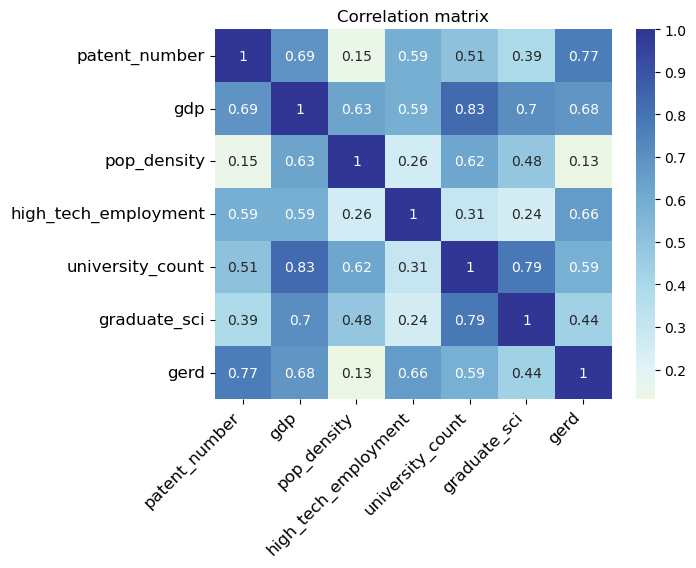

In [705]:
# List of columns that should be numeric
numeric_cols = ['gdp', 'pop_density', 'high_tech_employment', 'university_count', 'graduate_sci', 'gerd']

# Remove commas from the numeric columns and convert them to float
for col in numeric_cols:
    try:
        patent_counts_df[col] = patent_counts_df[col].replace(',', '', regex=True).astype(float)
    except ValueError as ve:
        print(f"ValueError in column {col}: {ve}")
        bad_values = patent_counts_df[pd.to_numeric(patent_counts_df[col], errors='coerce').isna()][col]
        print(f"Problematic values: {bad_values.unique()}")
        
# Calculate the correlation matrix
corr = patent_counts_df.drop(columns=['nuts218cd', 'nuts218nm', 'year']).corr()

# Plot the correlation matrix
sns.heatmap(corr, annot=True, cmap='RdYlBu', center=0)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation matrix')
plt.show()


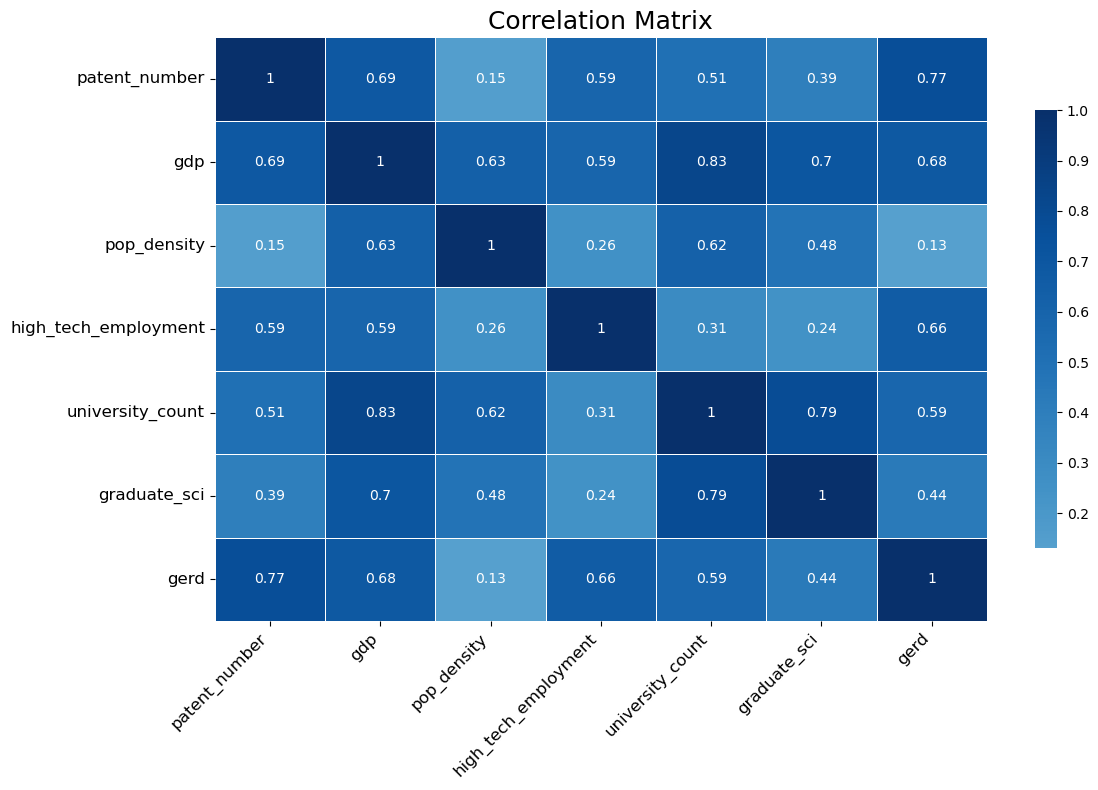

In [706]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns that should be numeric
numeric_cols = ['gdp', 'pop_density', 'high_tech_employment', 'university_count', 'graduate_sci', 'gerd']

# Remove commas from the numeric columns and convert them to float
for col in numeric_cols:
    try:
        patent_counts_df[col] = patent_counts_df[col].replace(',', '', regex=True).astype(float)
    except ValueError as ve:
        print(f"ValueError in column {col}: {ve}")
        bad_values = patent_counts_df[pd.to_numeric(patent_counts_df[col], errors='coerce').isna()][col]
        print(f"Problematic values: {bad_values.unique()}")

# Calculate the correlation matrix
corr = patent_counts_df.drop(columns=['nuts218cd', 'nuts218nm', 'year']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot the correlation matrix
sns.heatmap(corr, annot=True, cmap='Blues', center=0, linewidths=0.5, annot_kws={"size": 10}, cbar_kws={'shrink': 0.75})
plt.title('Correlation Matrix', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### 5.3 General Regression
#### 5.3.1 OLS
OLS regression of patent number on year, gdp, population density, high tech percentage, and university and college count

In [707]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [708]:
# Define the model
ols_model = smf.ols(formula='patent_number ~ gdp + pop_density + high_tech_employment + university_count + graduate_sci + gerd', data=patent_counts_df)

# Fit the model
ols_results = ols_model.fit()

# Print the summary
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:          patent_number   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     133.9
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           9.58e-89
Time:                        15:07:40   Log-Likelihood:                -959.97
No. Observations:                 369   AIC:                             1934.
Df Residuals:                     362   BIC:                             1961.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.3850 

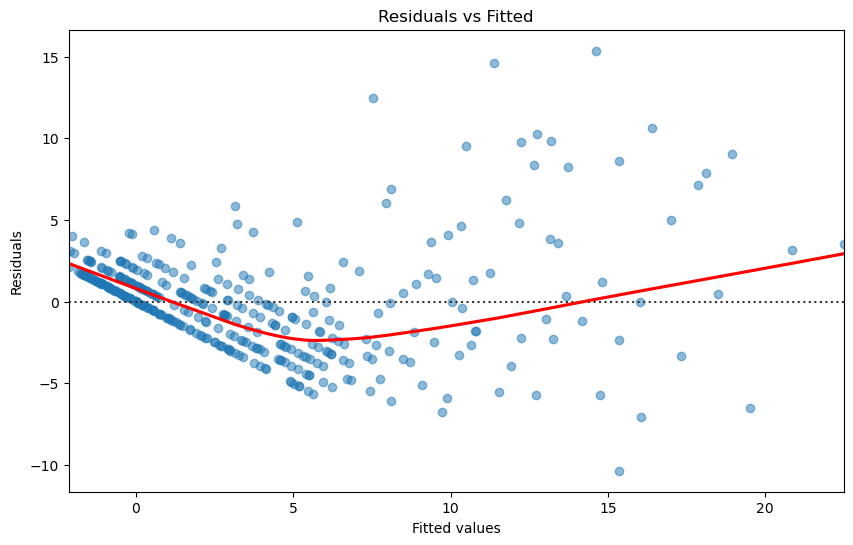

In [709]:
# plot the residuals
fig, ax = plt.subplots(figsize=(10, 6))
sns.residplot(x=ols_results.fittedvalues, y=ols_results.resid, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

#### 5.3.2 Poisson regression
Poisson regression of patent number on year, gdp, population density, high tech percentage, and university and college count

In [710]:
# Setting the corresponding independent and dependent variables
y = patent_counts_df['patent_number']
X = patent_counts_df[['gdp', 'pop_density', 'high_tech_employment', 'university_count', 'graduate_sci', 'gerd']]

# Poisson regression
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Output of results
print(poisson_model.summary())

# Calculate the marginal effects of Poisson regression
# Calculate the expected value
expected_y = np.exp(poisson_model.predict(X))

# Calculate marginal effects
marginal_effects = poisson_model.params * expected_y.mean()

print("Marginal effects:", marginal_effects)

                 Generalized Linear Model Regression Results                  
Dep. Variable:          patent_number   No. Observations:                  369
Model:                            GLM   Df Residuals:                      363
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -785.37
Date:                Thu, 08 Aug 2024   Deviance:                       768.63
Time:                        15:07:41   Pearson chi2:                     665.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9889
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
gdp                   3.831e-05 

#### 5.3.3 Zero-Inflated Poisson Regression
Zero-Inflated Poisson Regression of patent number on year, gdp, population density, high tech percentage, and university and college count

In [711]:
import statsmodels.api as cm

# Zero-Inflated Poisson Regression
zip_model = cm.ZeroInflatedPoisson(y, X).fit()

# Output of the result
print(zip_model.summary())

# Calculate the marginal effects of zero-inflated Poisson regression
# Calculate the expected value
expected_y = np.exp(zip_model.predict(X))

# Calculate marginal effects
marginal_effects = zip_model.params * expected_y.mean()

print("Marginal effects:", marginal_effects)

Optimization terminated successfully.
         Current function value: 2.057897
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:           patent_number   No. Observations:                  369
Model:             ZeroInflatedPoisson   Df Residuals:                      363
Method:                            MLE   Df Model:                            5
Date:                 Thu, 08 Aug 2024   Pseudo R-squ.:                  0.4317
Time:                         15:07:41   Log-Likelihood:                -759.36
converged:                        True   LL-Null:                       -1336.3
Covariance Type:             nonrobust   LLR p-value:                2.926e-247
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_co

#### 5.3.4 Summary of the regression results in publication style

In [712]:
from stargazer.stargazer import Stargazer
from IPython.display import display

# Create a Stargazer object with the fitted model results
stargazer = Stargazer([ols_results, poisson_model, zip_model])

# Customize the Stargazer output
stargazer.title("Regression Results")
stargazer.custom_columns(['OLS', 'Poisson', 'Zero-Inflated Poisson'], [1, 1, 1])
stargazer.significance_levels([0.1, 0.05, 0.01])
stargazer.show_degrees_of_freedom(False)
stargazer.show_confidence_intervals(False)  # Show standard errors instead of confidence intervals
stargazer.add_line('Observations', [369, 369, 369])  # Add a line for the number of observations
stargazer.show_model_numbers(False)  # Hide model numbers

# get the precision of the stargazer to 5 decimal places after the point
stargazer.covariate_order(['gdp', 'pop_density', 'high_tech_employment', 'university_count', 'graduate_sci', 'gerd'])
stargazer.significant_digits(6)  # Corrected line

# Show standard errors in parentheses next to the coefficients
stargazer.show_confidence_intervals(True)

# Display the stargazer object
display(stargazer)

In [739]:
from stargazer.stargazer import Stargazer
from IPython.display import display

# Create a Stargazer object with the fitted model results
stargazer = Stargazer([ols_results, poisson_model, zip_model])

# Customize the Stargazer output
stargazer.title("Regression Results")
stargazer.custom_columns(['OLS', 'Poisson', 'Zero-Inflated Poisson'], [1, 1, 1])
stargazer.significance_levels([0.1, 0.05, 0.01])
stargazer.show_degrees_of_freedom(False)
stargazer.show_confidence_intervals(False)  # Ensure standard errors are shown instead of confidence intervals
stargazer.add_line('Observations', [369, 369, 369])  # Add a line for the number of observations
stargazer.show_model_numbers(False)  # Hide model numbers

# Set significant digits to 4 decimal places
stargazer.significant_digits(5)

# Sort the covariates in a specific order (if needed)
stargazer.covariate_order(['gdp', 'pop_density', 'high_tech_employment', 'university_count', 'graduate_sci', 'gerd'])

# Display the stargazer object
display(stargazer)


In [713]:
patent_counts_df.sample(5)

nuts218cd  year                                         nuts218nm  \
190      UKI4  1999                               Inner London - East   
243      UKJ3  1998                       Hampshire and Isle of Wight   
266      UKK1  2003  Gloucestershire, Wiltshire and Bath/Bristol area   
302      UKL1  2003                                        West Wales   
323      UKM5  2006                            North Eastern Scotland   

     patent_number      gdp  pop_density  high_tech_employment  \
190            1.0  41654.0  8526.672986                   5.7   
243           14.0  27920.0   352.457622                   7.6   
266           22.0  44402.0   215.193597                   4.9   
302            1.0  22051.0   147.600000                   3.0   
323            2.0  12144.0    73.200000                   2.4   

     university_count  graduate_sci      gerd  
190             132.0  17689.833306   395.437  
243              88.0  12431.250014  1888.489  
266             125.0  16899.333288  2176.097  
302             110.0  13871.418794   246.133  
323              44.0   5060.916068   256.800

In [717]:
#find the different values in the 'nuts218cd' column
print(patent_counts_df['nuts218cd'].unique())

['UKC1' 'UKC2' 'UKD1' 'UKD3' 'UKD4' 'UKD6' 'UKD7' 'UKE1' 'UKE2' 'UKE3'
 'UKE4' 'UKF1' 'UKF2' 'UKF3' 'UKG1' 'UKG2' 'UKG3' 'UKH1' 'UKH2' 'UKH3'
 'UKI3' 'UKI4' 'UKI5' 'UKI6' 'UKI7' 'UKJ1' 'UKJ2' 'UKJ3' 'UKJ4' 'UKK1'
 'UKK2' 'UKK3' 'UKK4' 'UKL1' 'UKL2' 'UKM5' 'UKM6' 'UKM7' 'UKM8' 'UKM9'
 'UKN0']


In [718]:
# have a new column named nuts118cd, which is the first 3 characters of nuts218cd
patent_counts_df['nuts118cd'] = patent_counts_df['nuts218cd'].str[:3]

In [719]:
# find if UKC is in the 'nuts118cd' column
print('UKC' in patent_counts_df['nuts118cd'].unique())

True


In [726]:
# show the rows where nuts118cd is UKC
patent_counts_df[patent_counts_df['nuts118cd'] == 'UKC']


nuts218cd  year                         nuts218nm  patent_number      gdp  \
0       UKC1  1998            Tees Valley and Durham            0.0  12210.0   
1       UKC1  1999            Tees Valley and Durham            0.0  12708.0   
2       UKC1  2000            Tees Valley and Durham            0.0  13130.0   
3       UKC1  2001            Tees Valley and Durham            1.0  13365.0   
4       UKC1  2002            Tees Valley and Durham            0.0  14061.0   
5       UKC1  2003            Tees Valley and Durham            0.0  15070.0   
6       UKC1  2004            Tees Valley and Durham            1.0  16138.0   
7       UKC1  2005            Tees Valley and Durham            0.0  16734.0   
8       UKC1  2006            Tees Valley and Durham            1.0  17694.0   
9       UKC2  1998  Northumberland and Tyne and Wear            0.0  16605.0   
10      UKC2  1999  Northumberland and Tyne and Wear            0.0  16542.0   
11      UKC2  2000  Northumberland and Tyne and Wear            1.0  17008.0   
12      UKC2  2001  Northumberland and Tyne and Wear            2.0  18025.0   
13      UKC2  2002  Northumberland and Tyne and Wear            1.0  19449.0   
14      UKC2  2003  Northumberland and Tyne and Wear            0.0  20363.0   
15      UKC2  2004  Northumberland and Tyne and Wear            0.0  22247.0   
16      UKC2  2005  Northumberland and Tyne and Wear            0.0  23468.0   
17      UKC2  2006  Northumberland and Tyne and Wear            0.0  24649.0   

    pop_density  high_tech_employment  university_count  graduate_sci  \
0    389.200000                   3.1              44.0   6577.749917   
1    389.200000                   3.1              44.0   6995.250157   
2    389.200000                   3.1              44.0   7774.166504   
3    389.200000                   3.1              44.0   8340.416668   
4    389.200000                   3.1              44.0   8268.500011   
5    389.200000                   3.1              44.0   9809.910419   
6    389.200000                   3.1              44.0  10439.659514   
7    389.200000                   3.1              44.0  10595.158770   
8    389.200000                   3.1              44.0  10815.075948   
9   2043.600372                   4.2              66.0  12218.708665   
10  2028.273234                   4.2              66.0  12206.333245   
11  2016.289963                   4.2              66.0  11954.583160   
12  2012.104089                   4.2              66.0  11518.250244   
13  2012.799257                   4.2              66.0  11527.250167   
14  2010.901487                   4.2              66.0  11820.792475   
15  2008.565056                   4.2              66.0  12154.416925   
16  2015.157993                   4.2              66.0  13446.500259   
17  2018.126394                   4.2              66.0  11589.083446   

       gerd nuts118cd  
0   233.494       UKC  
1   233.494       UKC  
2   233.494       UKC  
3   233.494       UKC  
4   233.494       UKC  
5   233.494       UKC  
6   233.494       UKC  
7   233.494       UKC  
8   233.494       UKC  
9   273.308       UKC  
10  273.308       UKC  
11  273.308       UKC  
12  273.308       UKC  
13  273.308       UKC  
14  273.308       UKC  
15  273.308       UKC  
16  273.308       UKC  
17  273.308       UKC

### 5.4 Treat nuts1 as a dummy variable
#### 5.4.1 OLS

In [729]:
# get a copy of dataframe
df2 = patent_counts_df.copy()

# treat nuts1 as a dummy variable
df2 = pd.get_dummies(df2, columns=['nuts118cd'])

# for all values in the dataframe, replace 1 with bool value 'True' and 0 with 'False'
df2 = df2.replace({True: 1, False: 0})


In [730]:
df2

nuts218cd  year               nuts218nm  patent_number      gdp  \
0        UKC1  1998  Tees Valley and Durham            0.0  12210.0   
1        UKC1  1999  Tees Valley and Durham            0.0  12708.0   
2        UKC1  2000  Tees Valley and Durham            0.0  13130.0   
3        UKC1  2001  Tees Valley and Durham            1.0  13365.0   
4        UKC1  2002  Tees Valley and Durham            0.0  14061.0   
..        ...   ...                     ...            ...      ...   
364      UKN0  2002        Northern Ireland            0.0  24045.0   
365      UKN0  2003        Northern Ireland            2.0  25966.0   
366      UKN0  2004        Northern Ireland            0.0  27241.0   
367      UKN0  2005        Northern Ireland            2.0  28755.0   
368      UKN0  2006        Northern Ireland            2.0  30496.0   

     pop_density  high_tech_employment  university_count  graduate_sci  \
0          389.2                   3.1              44.0   6577.749917   
1          389.2                   3.1              44.0   6995.250157   
2          389.2                   3.1              44.0   7774.166504   
3          389.2                   3.1              44.0   8340.416668   
4          389.2                   3.1              44.0   8268.500011   
..           ...                   ...               ...           ...   
364        133.8                   3.8               0.0      0.000000   
365        133.8                   3.8               0.0      0.000000   
366        133.8                   3.8               0.0      0.000000   
367        133.8                   3.8               0.0      0.000000   
368        133.8                   3.8               0.0      0.000000   

        gerd  ...  nuts118cd_UKE  nuts118cd_UKF  nuts118cd_UKG  nuts118cd_UKH  \
0    233.494  ...              0              0              0              0   
1    233.494  ...              0              0              0              0   
2    233.494  ...              0              0              0              0   
3    233.494  ...              0              0              0              0   
4    233.494  ...              0              0              0              0   
..       ...  ...            ...            ...            ...            ...   
364  420.648  ...              0              0              0              0   
365  420.648  ...              0              0              0              0   
366  420.648  ...              0              0              0              0   
367  420.648  ...              0              0              0              0   
368  420.648  ...              0              0              0              0   

     nuts118cd_UKI  nuts118cd_UKJ  nuts118cd_UKK  nuts118cd_UKL  \
0                0              0              0              0   
1                0              0              0              0   
2                0              0              0              0   
3                0              0              0              0   
4                0              0              0              0   
..             ...            ...            ...            ...   
364              0              0              0              0   
365              0              0              0              0   
366              0              0              0              0   
367              0              0              0              0   
368              0              0              0              0   

     nuts118cd_UKM  nuts118cd_UKN  
0                0              0  
1                0              0  
2                0              0  
3                0              0  
4                0              0  
..             ...            ...  
364              0              1  
365              0              1  
366              0              1  
367              0              1  
368              0              1  

[369 rows x 22 columns]

In [731]:
df2.columns

Index(['nuts218cd', 'year', 'nuts218nm', 'patent_number', 'gdp', 'pop_density',
       'high_tech_employment', 'university_count', 'graduate_sci', 'gerd',
       'nuts118cd_UKC', 'nuts118cd_UKD', 'nuts118cd_UKE', 'nuts118cd_UKF',
       'nuts118cd_UKG', 'nuts118cd_UKH', 'nuts118cd_UKI', 'nuts118cd_UKJ',
       'nuts118cd_UKK', 'nuts118cd_UKL', 'nuts118cd_UKM', 'nuts118cd_UKN'],
      dtype='object')

In [732]:
# use the dummy variable to run the OLS regression
import statsmodels.api as sm
X = df2.drop(columns=['patent_number','nuts218nm', 'nuts218cd'])
y = df2['patent_number']
X = sm.add_constant(X)
ols_model_2 = sm.OLS(y, X).fit()

# print the summary of the model
print(ols_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:          patent_number   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     54.52
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           6.83e-90
Time:                        15:12:15   Log-Likelihood:                -929.22
No. Observations:                 369   AIC:                             1896.
Df Residuals:                     350   BIC:                             1971.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -185.3016 

In [742]:
ols_model_2.params

const                  -185.301632
year                      0.098693
gdp                       0.000254
pop_density              -0.000866
high_tech_employment     -0.073472
university_count         -0.018090
graduate_sci             -0.000039
gerd                      0.003789
nuts118cd_UKC           -14.504999
nuts118cd_UKD           -16.740780
nuts118cd_UKE           -15.080460
nuts118cd_UKF           -15.983334
nuts118cd_UKG           -16.142662
nuts118cd_UKH           -16.826100
nuts118cd_UKI           -13.169377
nuts118cd_UKJ           -15.151438
nuts118cd_UKK           -12.972302
nuts118cd_UKL           -15.514402
nuts118cd_UKM           -14.347020
nuts118cd_UKN           -18.868758
dtype: float64

In [743]:
ols_model_2.bse

const                   139.859630
year                      0.075739
gdp                       0.000036
pop_density               0.000234
high_tech_employment      0.168741
university_count          0.006831
graduate_sci              0.000043
gerd                      0.000505
nuts118cd_UKC            11.781936
nuts118cd_UKD            11.726324
nuts118cd_UKE            11.695784
nuts118cd_UKF            11.707734
nuts118cd_UKG            11.604911
nuts118cd_UKH            11.703005
nuts118cd_UKI            11.700866
nuts118cd_UKJ            11.551544
nuts118cd_UKK            11.672566
nuts118cd_UKL            11.752000
nuts118cd_UKM            11.765869
nuts118cd_UKN            11.463931
dtype: float64

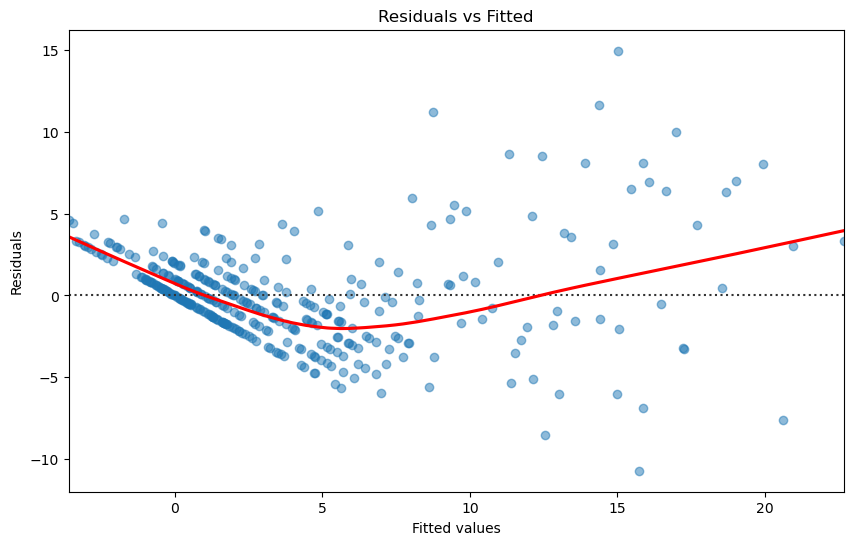

In [733]:
# plot the residuals based on the ols_model_2 result

fig, ax = plt.subplots(figsize=(10, 6))
sns.residplot(x=ols_model_2.fittedvalues, y=ols_model_2.resid, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

#### 5.4.2 Poisson regression

In [734]:
# Setting the corresponding independent and dependent variables
X = df2.drop(columns=['patent_number','nuts218nm', 'nuts218cd'])
y = df2['patent_number']

# Poisson regression
poisson_model_2 = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Output of results
print(poisson_model_2.summary())

# Calculate the marginal effects of Poisson regression
# Calculate the expected value
expected_y = np.exp(poisson_model_2.predict(X))

# Calculate marginal effects
marginal_effects = poisson_model_2.params * expected_y.mean()

print("Marginal effects:", marginal_effects)

                 Generalized Linear Model Regression Results                  
Dep. Variable:          patent_number   No. Observations:                  369
Model:                            GLM   Df Residuals:                      350
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -687.51
Date:                Thu, 08 Aug 2024   Deviance:                       572.92
Time:                        15:12:20   Pearson chi2:                     525.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9934
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
year                     0.0476 

In [744]:
poisson_model_2.params


year                     0.047588
gdp                      0.000023
pop_density             -0.000247
high_tech_employment     0.011882
university_count        -0.001199
graduate_sci             0.000058
gerd                     0.000411
nuts118cd_UKC          -97.036545
nuts118cd_UKD          -96.224988
nuts118cd_UKE          -96.267897
nuts118cd_UKF          -95.939180
nuts118cd_UKG          -95.714706
nuts118cd_UKH          -95.186874
nuts118cd_UKI          -94.690510
nuts118cd_UKJ          -95.242198
nuts118cd_UKK          -95.200312
nuts118cd_UKL          -96.397331
nuts118cd_UKM          -95.879250
nuts118cd_UKN          -96.171954
dtype: float64

In [745]:
poisson_model_2.bse

year                     0.014723
gdp                      0.000005
pop_density              0.000046
high_tech_employment     0.024148
university_count         0.001103
graduate_sci             0.000008
gerd                     0.000067
nuts118cd_UKC           29.480597
nuts118cd_UKD           29.459583
nuts118cd_UKE           29.459353
nuts118cd_UKF           29.460565
nuts118cd_UKG           29.450475
nuts118cd_UKH           29.472358
nuts118cd_UKI           29.468054
nuts118cd_UKJ           29.444256
nuts118cd_UKK           29.454776
nuts118cd_UKL           29.477919
nuts118cd_UKM           29.487410
nuts118cd_UKN           29.428766
dtype: float64

#### 5.6.3 Zero-Inflated Poisson Regression

In [735]:
import statsmodels.api as cm

# Zero-Inflated Poisson Regression
zip_model_2 = cm.ZeroInflatedPoisson(y, X).fit()

# Output of the result
print(zip_model_2.summary())

# Calculate the marginal effects of zero-inflated Poisson regression
# Calculate the expected value
expected_y = np.exp(zip_model_2.predict(X))

# Calculate marginal effects
marginal_effects = zip_model_2.params * expected_y.mean()

print("Marginal effects:", marginal_effects)

         Current function value: 2.603863
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:           patent_number   No. Observations:                  369
Model:             ZeroInflatedPoisson   Df Residuals:                      350
Method:                            MLE   Df Model:                           18
Date:                 Thu, 08 Aug 2024   Pseudo R-squ.:                  0.2810
Time:                         15:12:23   Log-Likelihood:                -960.83
converged:                       False   LL-Null:                       -1336.3
Covariance Type:             nonrobust   LLR p-value:                8.731e-148
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            0.1000      0.110      0.

/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1331: RuntimeWarning: overflow encountered in exp
  return -np.exp(XB) +  endog*XB - gammaln(endog+1)
/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1508: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1509: RuntimeWarning: invalid value encountered in multiply
  return (self.endog - L)[:,None] * X
/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/count_model.py:269: RuntimeWarning: invalid value encountered in multiply
  dldp[zero_idx,:] = (score_main[zero_idx].T *
/Users/yuhanzhou/anaconda3/lib/python3.11/site

In [746]:
zip_model_2.params


inflate_const           0.100000
year                    0.000127
gdp                     0.000022
pop_density            -0.000149
high_tech_employment    0.000066
university_count        0.000072
graduate_sci            0.000055
gerd                    0.000127
nuts118cd_UKC          -0.000098
nuts118cd_UKD          -0.000009
nuts118cd_UKE          -0.000024
nuts118cd_UKF           0.000015
nuts118cd_UKG           0.000004
nuts118cd_UKH           0.000052
nuts118cd_UKI           0.000044
nuts118cd_UKJ           0.000059
nuts118cd_UKK           0.000036
nuts118cd_UKL          -0.000057
nuts118cd_UKM           0.000026
nuts118cd_UKN          -0.000077
dtype: float64

In [747]:
zip_model_2.bse

inflate_const            0.109699
year                     0.014990
gdp                      0.000005
pop_density              0.000045
high_tech_employment     0.028753
university_count         0.001105
graduate_sci             0.000008
gerd                     0.000075
nuts118cd_UKC           30.025047
nuts118cd_UKD           29.998752
nuts118cd_UKE           30.001530
nuts118cd_UKF           29.998990
nuts118cd_UKG           29.994850
nuts118cd_UKH           29.998891
nuts118cd_UKI           30.001668
nuts118cd_UKJ           29.972114
nuts118cd_UKK           29.991161
nuts118cd_UKL           30.023011
nuts118cd_UKM           30.031957
nuts118cd_UKN           29.963999
dtype: float64

#### 5.6.4 Publication-style Summary of Regression Results when Treating Region as a Dummy Variable

In [736]:
from stargazer.stargazer import Stargazer

# Create a Stargazer object with the fitted model results
stargazer_1 = Stargazer([ols_model_2, poisson_model_2, zip_model_2])

# Customize the Stargazer output
stargazer_1.title("Regression Results when Treating Region as a Dummy Variable")
stargazer_1.custom_columns(['OLS', 'Poisson', 'Zero-Inflated Poisson'], [1, 1, 1])
stargazer_1.significance_levels([0.1, 0.05, 0.01])
stargazer_1.show_degrees_of_freedom(False)
stargazer_1.show_confidence_intervals(True)

# Display the Stargazer object
stargazer_1

In [741]:
from stargazer.stargazer import Stargazer
from IPython.display import display

# Create a Stargazer object with the fitted model results
stargazer_1 = Stargazer([ols_model_2, poisson_model_2, zip_model_2])


# Customize the Stargazer output
stargazer_1.title("Regression Results when Treating Region as a Dummy Variable")
stargazer_1.custom_columns(['OLS', 'Poisson', 'Zero-Inflated Poisson'], [1, 1, 1])
stargazer_1.significance_levels([0.1, 0.05, 0.01])
stargazer_1.show_degrees_of_freedom(False)
stargazer_1.show_confidence_intervals(False)  # Ensure standard errors are shown instead of confidence intervals
stargazer_1.add_line('Observations', [369, 369, 369])  # Add a line for the number of observations
stargazer_1.show_model_numbers(False)  # Hide model numbers

# Set significant digits to 4 decimal places
stargazer_1.significant_digits(5)

# Display the stargazer object
display(stargazer_1)


### 5.7 Panel Regression

In [287]:
import pyfixest as pf

In [288]:
# Define the fixed effects model
pf.feols('patent_number ~ gdp + pop_density + gerd + high_tech_employment + university_count + graduate_sci | nuts218cd + year', data=patent_counts_df).summary()


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/yuhanzhou/anaconda3/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:1987: UserWarning: 
            The following variables are collinear: ['gerd', 'high_tech_employment', 'university_count'].
            The variables are dropped from the model.
            
  warnings.warn(


###

Estimation:  OLS
Dep. var.: patent_number, Fixed effects: nuts218cd+year
Inference:  CRV1
Observations:  369

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| gdp           |      0.001 |        0.000 |     4.398 |      0.000 |  0.000 |   0.001 |
| pop_density   |     -0.008 |        0.004 |    -2.307 |      0.026 | -0.016 |  -0.001 |
| graduate_sci  |      0.001 |        0.000 |     2.115 |      0.041 |  0.000 |   0.002 |
---
RMSE: 2.303 R2: 0.845 R2 Within: 0.223 


In [289]:
pf.fepois("patent_number ~ gdp + pop_density + high_tech_employment + university_count + graduate_sci + gerd | nuts218cd + year", data = patent_counts_df).summary()

###

Estimation:  Poisson
Dep. var.: patent_number, Fixed effects: nuts218cd+year
Inference:  CRV1
Observations:  369

| Coefficient          |               Estimate |            Std. Error |   t value |   Pr(>|t|) |                   2.5% |                  97.5% |
|:---------------------|-----------------------:|----------------------:|----------:|-----------:|-----------------------:|-----------------------:|
| gdp                  |                  0.000 |                 0.000 |     0.240 |      0.810 |                 -0.000 |                  0.000 |
| pop_density          |                 -0.000 |                 0.000 |    -0.127 |      0.899 |                 -0.001 |                  0.001 |
| high_tech_employment | 130318078175883968.000 | 95358101496471488.000 |     1.367 |      0.172 | -56580366391315168.000 | 317216522743083136.000 |
| university_count     | -11186985663581930.000 |  7083811163733560.000 |    -1.579 |      0.114 | -25071000417782476.000 |   2697029090